https://www.kaggle.com/competitions/rossmann-store-sales/

# **Todo**



Analyze These Columns

'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval'

# ***Informations***

## Exploratory Data Analysis and Visualization

Objectives of exploratory data analysis:

- Study the distributions of individual columns (uniform, normal, exponential)
- Detect anomalies or errors in the data (e.g. missing/incorrect values)
- Study the relationship of target column with other columns (linear, non-linear etc.)
- Gather insights about the problem and the dataset
- Come up with ideas for preprocessing and feature engineering

# ***Imports***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
%matplotlib inline

plt.style.use("Solarize_Light2")

# ***Load Datasets***

In [ ]:
import gdown

# Replace with your Google Drive shareable link
url = 'https://drive.google.com/file/d/1PogAVq1OtCFCU37GKUN-LPfjuGML6npk/view?usp=sharing'

# Convert to the direct download link
file_id = url.split('/d/')[1].split('/')[0]
direct_url = f'https://drive.google.com/uc?id={file_id}'

# Download
gdown.download(direct_url, 'Rossmann.zip', quiet=False)

!unzip -o /content/Rossmann.zip -d /content/Rossmann

train_data = pd.read_csv("/content/Rossmann/train.csv", low_memory=False)
store_data = pd.read_csv("/content/Rossmann/store.csv")

test_data = pd.read_csv("/content/Rossmann/test.csv")
sample_submission_data = pd.read_csv("/content/Rossmann/sample_submission.csv")

Downloading...
From: https://drive.google.com/uc?id=1PogAVq1OtCFCU37GKUN-LPfjuGML6npk
To: /content/Rossmann.zip
100%|██████████| 7.33M/7.33M [00:00<00:00, 177MB/s]


Archive:  /content/Rossmann.zip
  inflating: /content/Rossmann/sample_submission.csv  
  inflating: /content/Rossmann/store.csv  
  inflating: /content/Rossmann/test.csv  
  inflating: /content/Rossmann/train.csv  


In [ ]:
train_data["StateHoliday"] = train_data.StateHoliday.replace({0: '0'})
train_data.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

## Heads

In [ ]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# ***Join Train & Stores***

In [ ]:
data = train_data.merge(right=store_data, how="inner", on="Store").copy()
data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [ ]:
# if rows count not equals to each other you can use left join for merge.
train_data.shape, data.shape

((1017209, 9), (1017209, 18))

# ***Reorder Columns***

In [ ]:
targets = ["Sales", "Customers"]
columns = [col for col in list(data.columns) if col not in targets]
data = data.loc[:, columns + targets]
data.head(2)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers
0,1,5,2015-07-31,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5263,555
1,2,5,2015-07-31,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6064,625


# ***Convert Date to DateTime***

In [ ]:
data["Date"] = pd.to_datetime(data.Date)
data["Date"].dt.dayofyear.head(2)

,Date
0,212
1,212


# **Each Store Sales**

Total sales per store

In [ ]:
sales_by_store = data.groupby("Store")["Sales"].sum().sort_values(ascending=False)
sales_by_store.head()

,Sales
Store,
262,19516842
817,17057867
562,16927322
1114,16202585
251,14896870


In [ ]:
sales_by_store.sum() == data["Sales"].sum()

np.True_

Total sales per year

In [ ]:
sales_by_y = data.groupby(["Store", data.Date.dt.year])[["Sales"]].sum().sort_values(by="Date" ,ascending=False)
sales_by_y.head()

,,Sales
Store,Date,
1107,2015,1105610
1106,2015,886655
1115,2015,1242048
1110,2015,865479
5,2015,816125


Total sales per month

In [ ]:
data["Year"] = data.Date.dt.year
data["Month"] = data.Date.dt.month
sales_by_ym = data.groupby(["Store", "Year", "Month"])[["Sales"]].sum().sort_values(by=["Store", "Year", "Month"], ascending=True)
sales_by_ym.head(12)

Sales
Store Year Month        
1     2013 1      128431
           2      125271
           3      145169
           4      118009
           5      118225
           6      113411
           7      128032
           8      118320
           9      108867
           10     114641
           11     127596
           12     145168

# ***Plots***

## **Categorize Sales**
very low, low, med, high and very high

In [ ]:
data.Sales.describe()

,Sales
count,1.017209e+06
mean,5.773819e+03
std,3.849926e+03
min,0.000000e+00
25%,3.727000e+03
50%,5.744000e+03
75%,7.856000e+03
max,4.155100e+04


In [ ]:
# custom bins base on data.Sales.describe()
bins = [0, 3727, 5744, 7856, 15000, 42000]
labels = ['very low', 'low', 'med', 'high', 'very high']
sales_category = pd.cut(data['Sales'], bins=bins, labels=labels, include_lowest=True)

## **Check for Missing and Duplicate Data**

In [ ]:
data.isnull().sum(), data.duplicated().sum()

(Store                             0
 DayOfWeek                         0
 Date                              0
 Open                              0
 Promo                             0
 StateHoliday                      0
 SchoolHoliday                     0
 StoreType                         0
 Assortment                        0
 CompetitionDistance            2642
 CompetitionOpenSinceMonth    323348
 CompetitionOpenSinceYear     323348
 Promo2                            0
 Promo2SinceWeek              508031
 Promo2SinceYear              508031
 PromoInterval                508031
 Sales                             0
 Customers                         0
 Year                              0
 Month                             0
 dtype: int64,
 np.int64(0))

## **Correlation Matrix**

### Heatmap

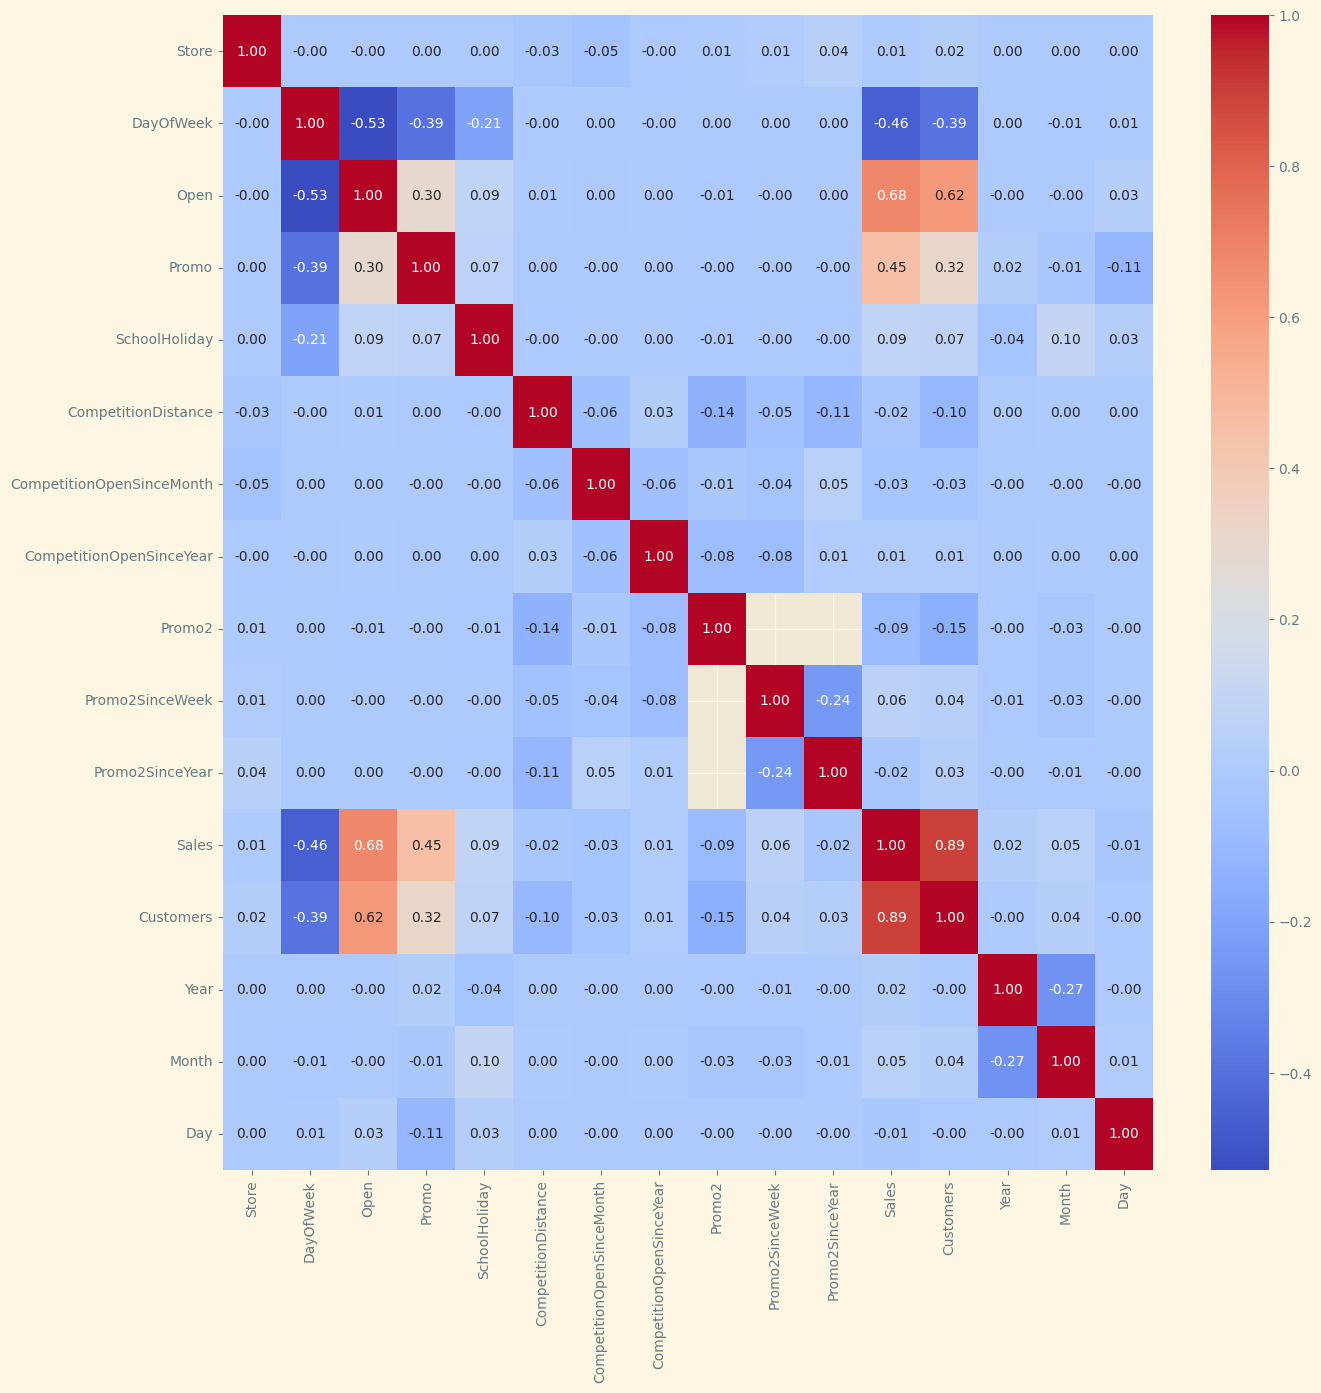

In [ ]:
data_temp = data.copy()

data_temp["Year"] = data["Date"].dt.year.copy()
data_temp["Month"] = data["Date"].dt.month.copy()
data_temp["Day"] = data["Date"].dt.day.copy()

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(data=data_temp[data_temp.select_dtypes(include=[np.number]).columns].corr(),
         annot=True,
         cmap="coolwarm",
         fmt=".2f",
         ax=ax)

plt.show()

### DF

In [ ]:
data_temp[data_temp.select_dtypes(include=[np.number]).columns].corr()["Sales"].sort_values(ascending=False)

,Sales
Sales,1.000000
Customers,0.894711
Open,0.678472
Promo,0.452345
SchoolHoliday,0.085124
Promo2SinceWeek,0.059558
Month,0.048768
Year,0.023519
CompetitionOpenSinceYear,0.012659
Store,0.005126


## **Recommended Plots**

In [ ]:
data

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers,Year,Month
0,1,5,2015-07-31,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5263,555,2015,7
1,2,5,2015-07-31,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6064,625,2015,7
2,3,5,2015-07-31,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",8314,821,2015,7
3,4,5,2015-07-31,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,13995,1498,2015,7
4,5,5,2015-07-31,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,4822,559,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0,0,2013,1
1017205,1112,2,2013-01-01,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,0,0,2013,1
1017206,1113,2,2013-01-01,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,0,0,2013,1
1017207,1114,2,2013-01-01,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,0,0,2013,1


## **Univariate Analysis (One feature at a time)**

### Histogram

figsize=(10, 6): Makes plots larger and more readable.

multiple='stack': Stacks bars by hue for better comparison.

palette='Set2': Uses a more distinct color palette.

edgecolor & linewidth: Adds outlines to bars for better separation.

tight_layout(): Prevents overlapping labels.

legend customization for clarity.

Rotated x-axis labels (useful for categorical or tightly packed values).

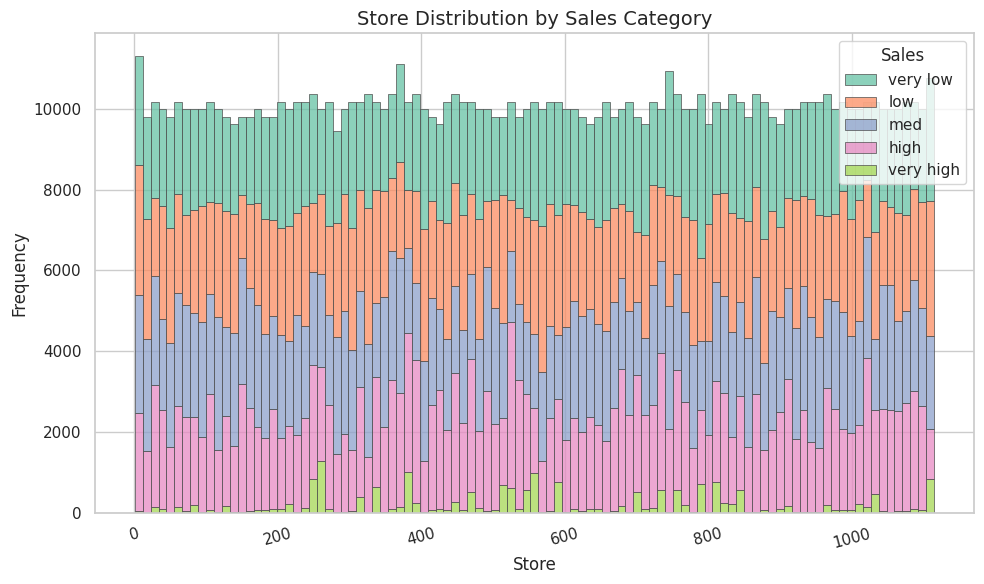

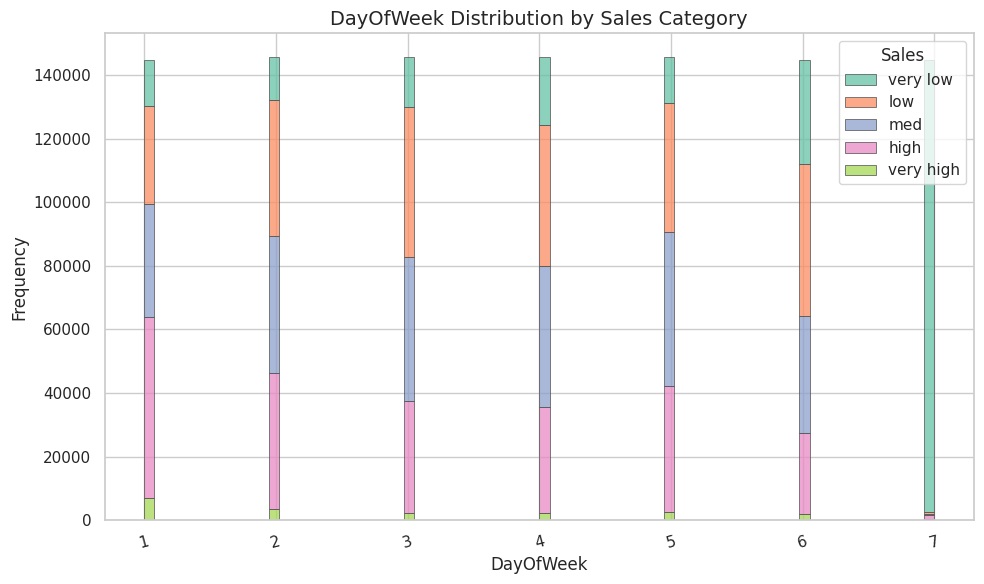

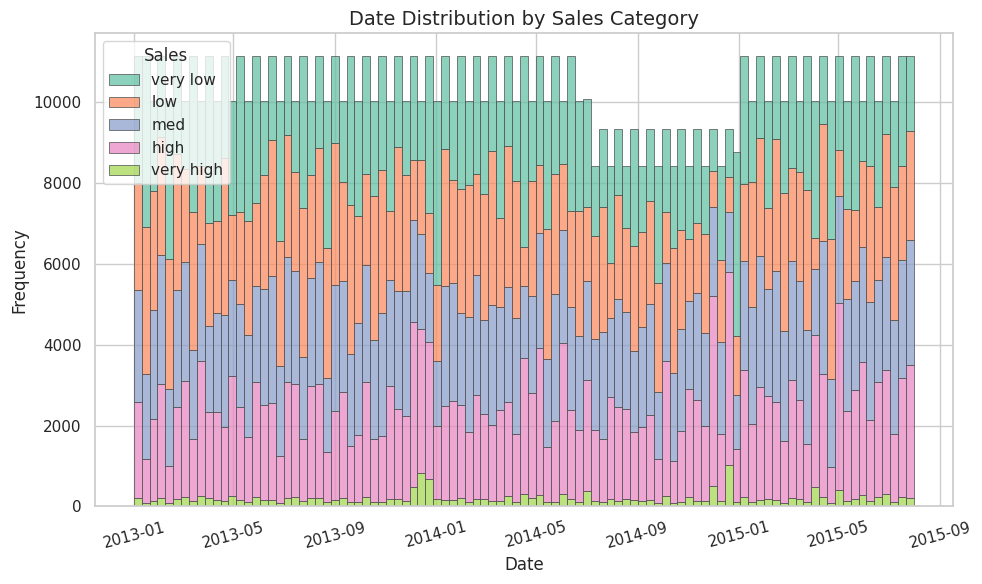

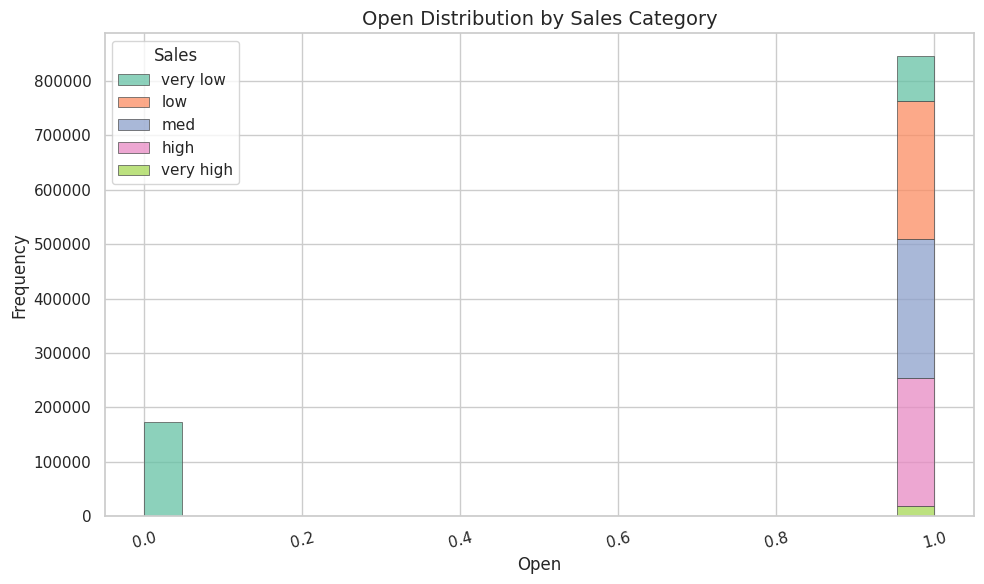

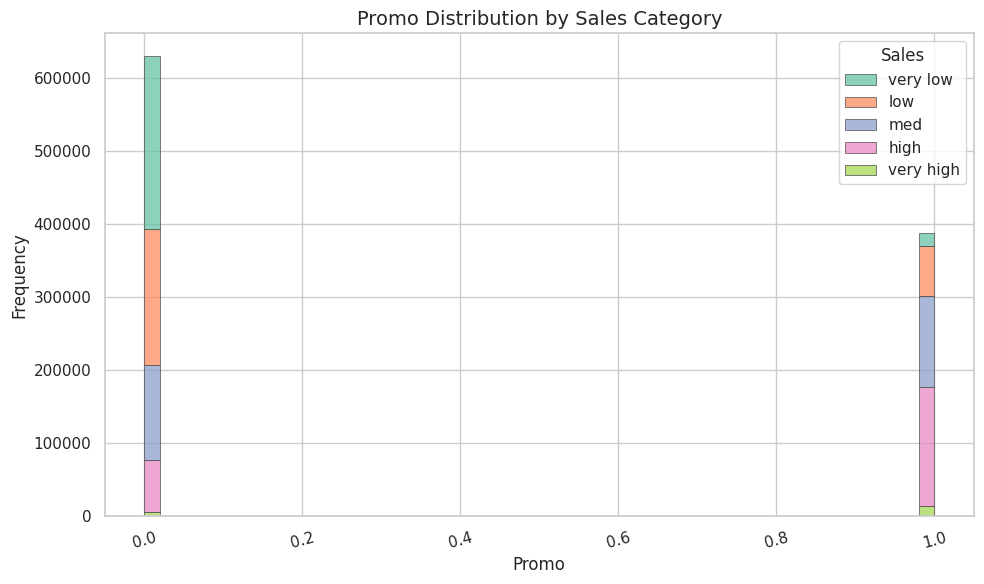

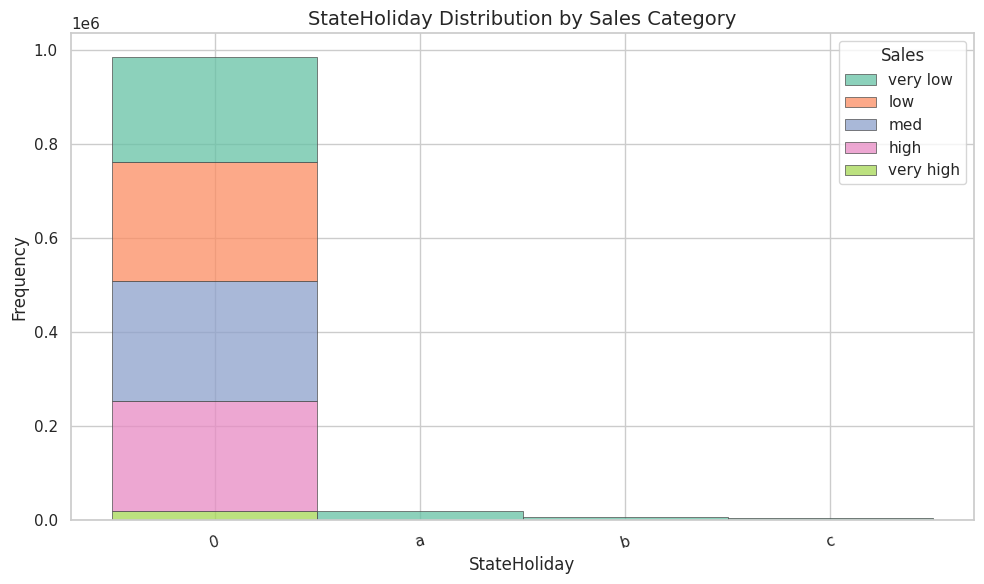

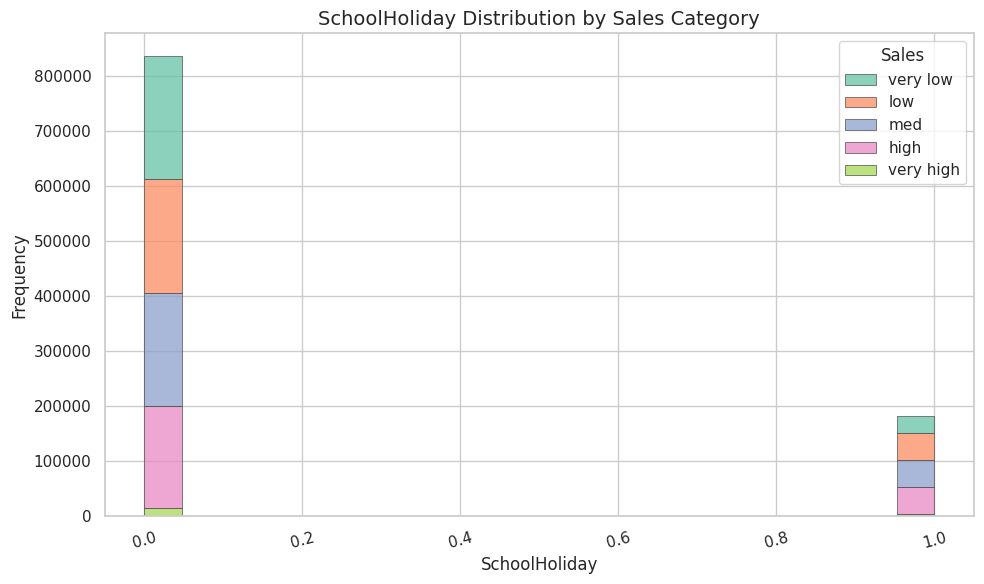

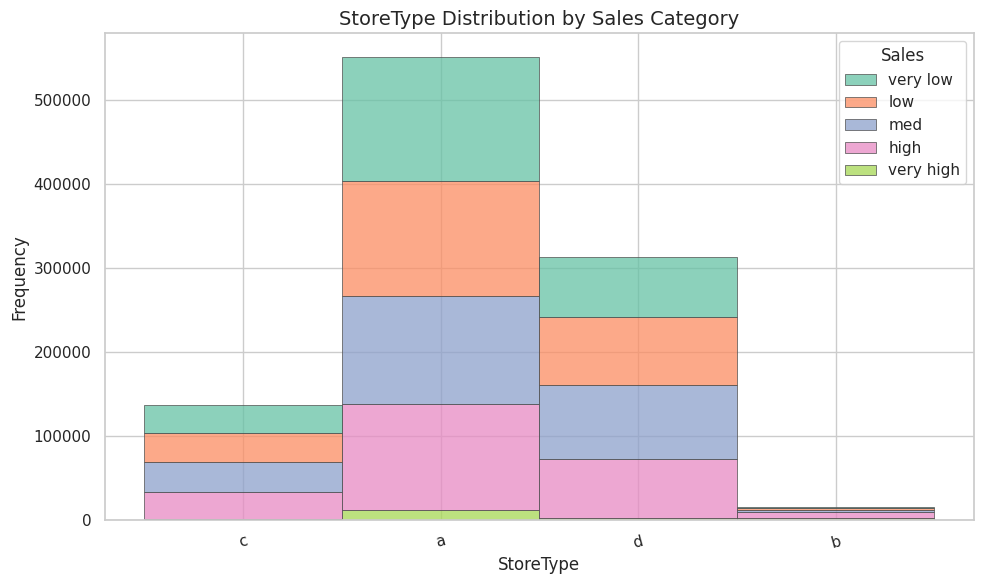

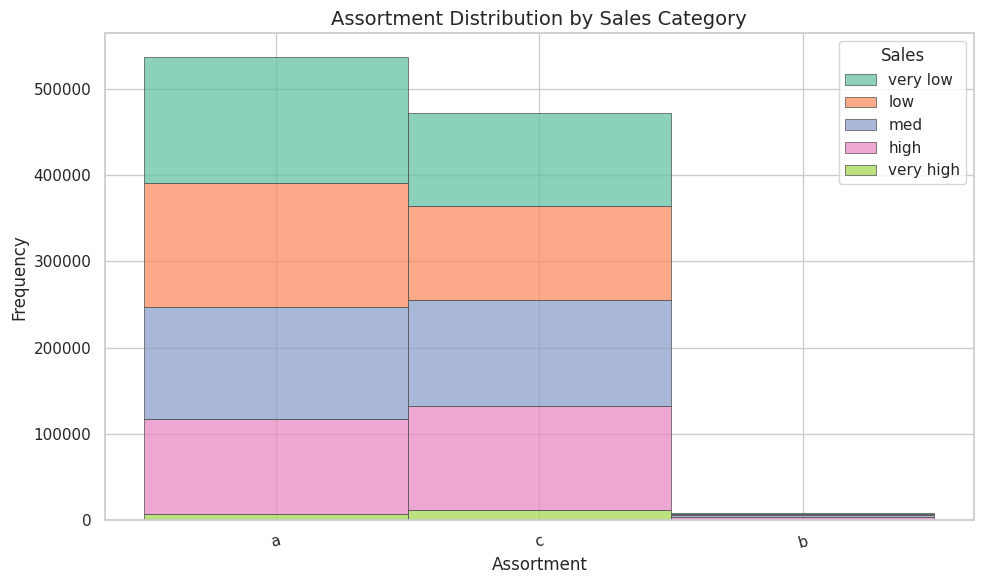

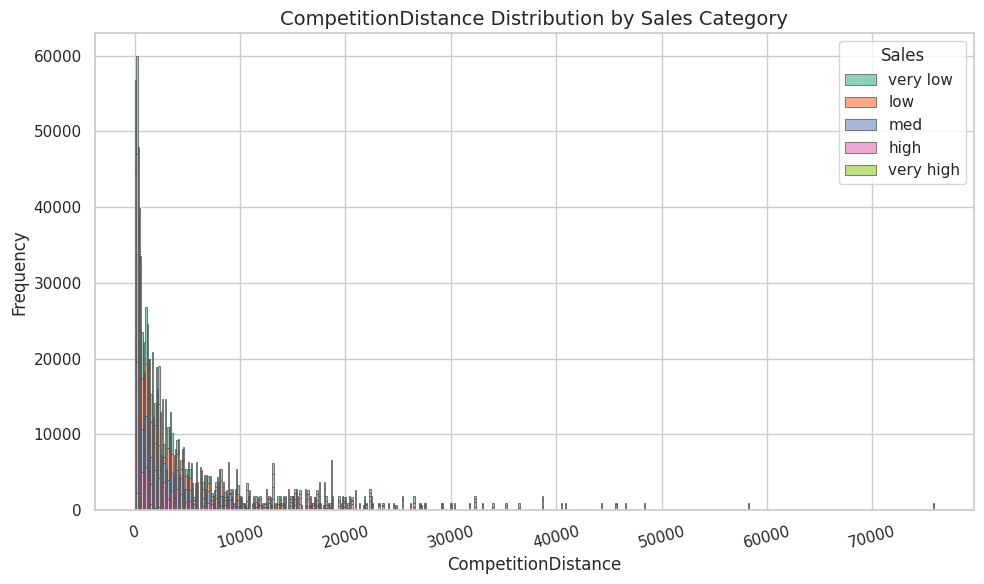

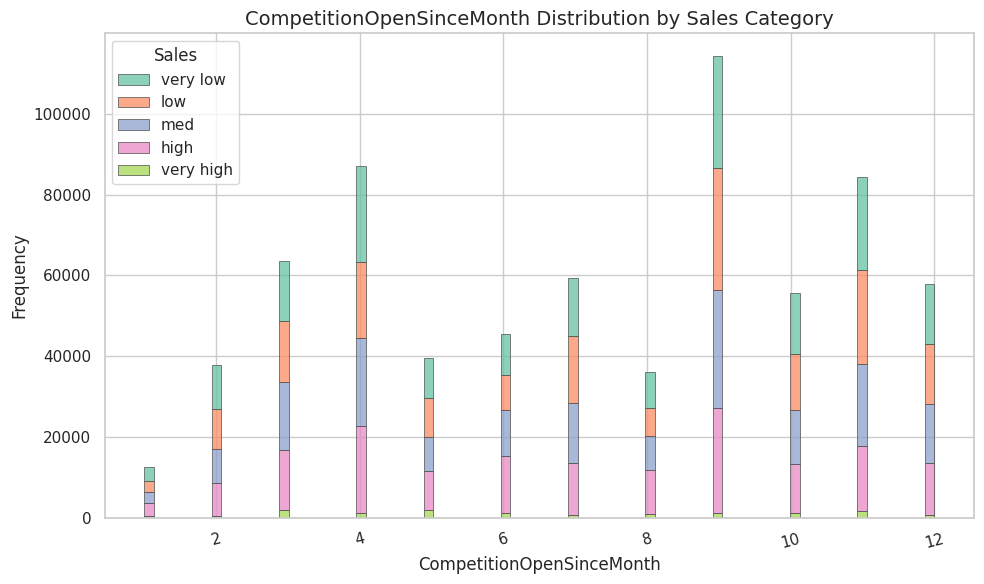

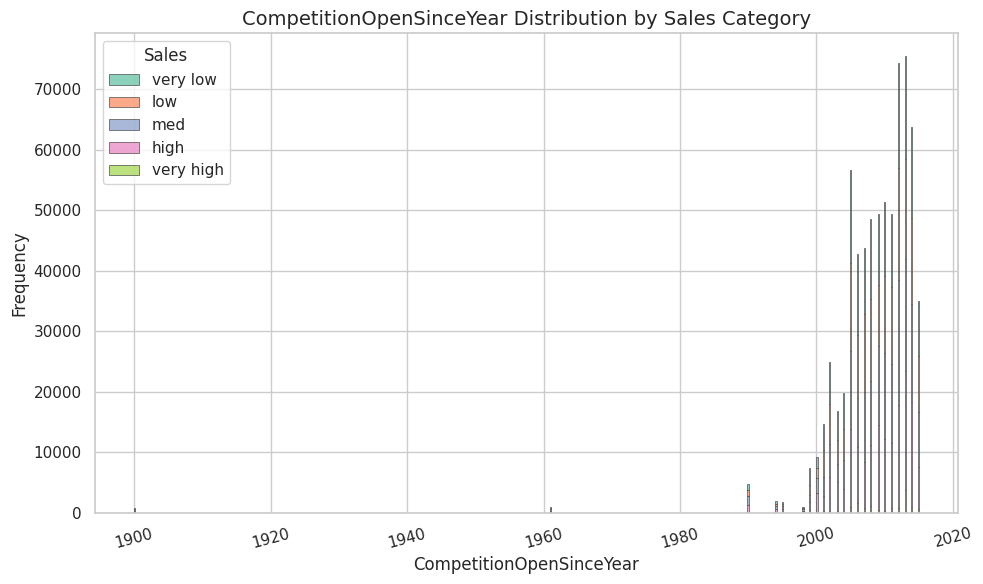

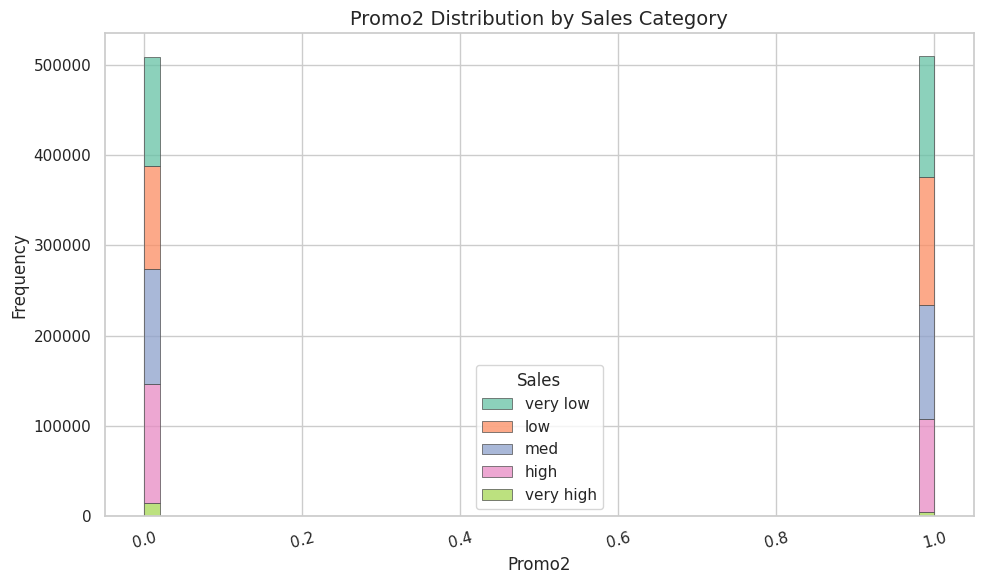

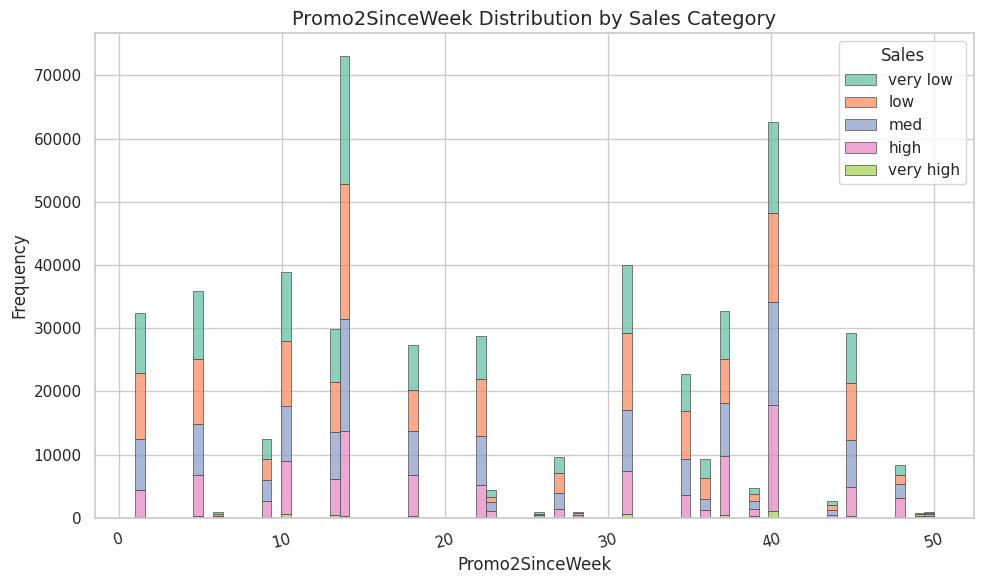

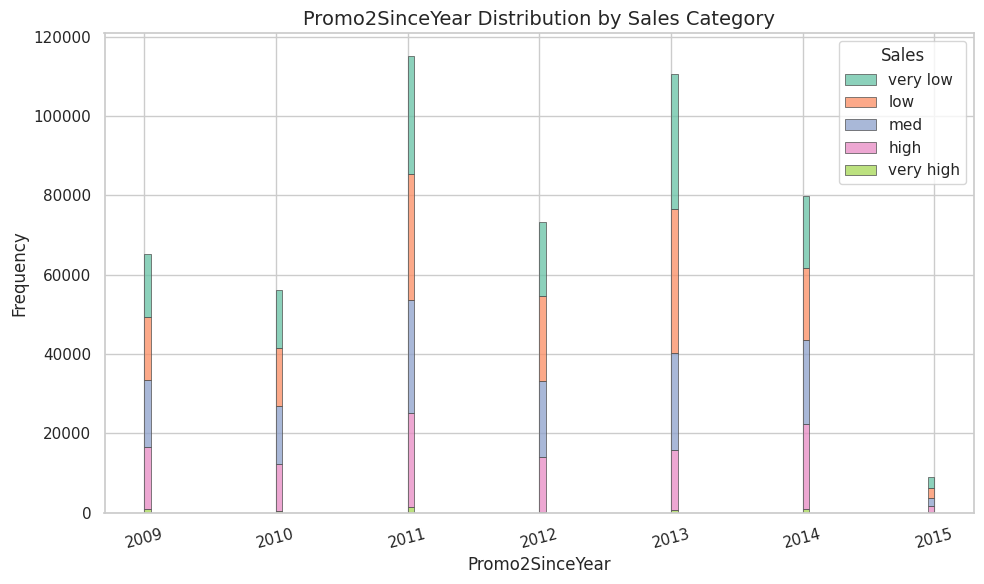

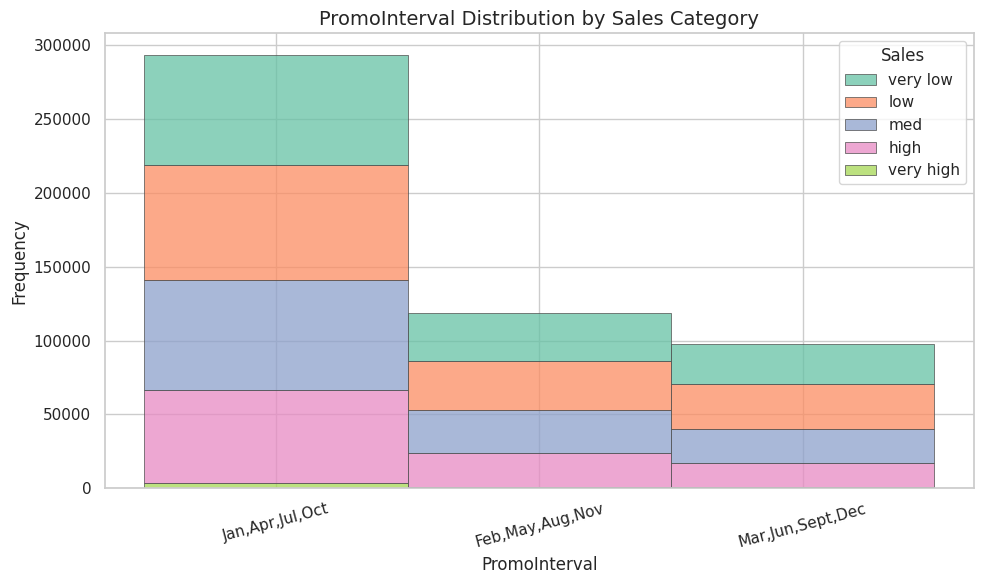

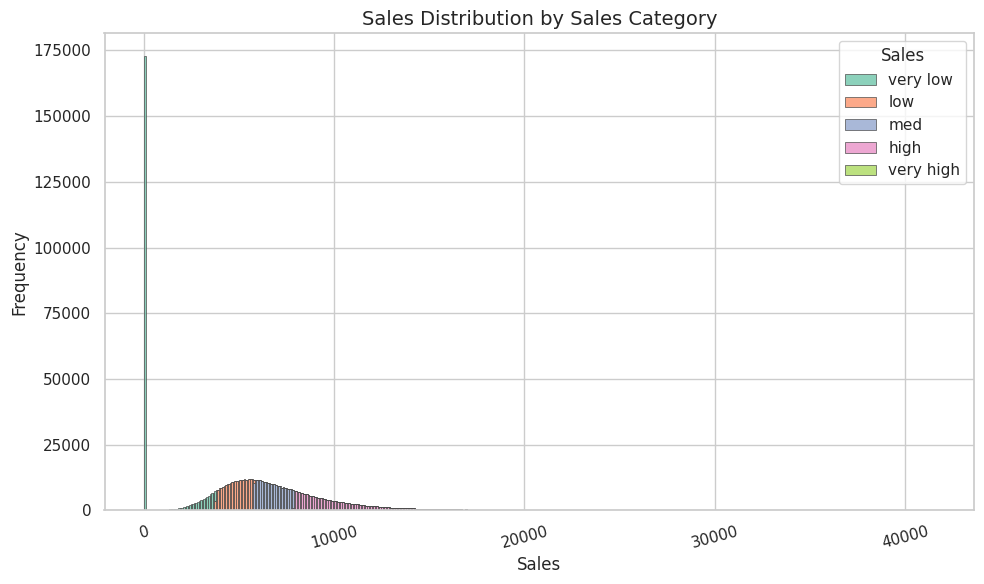

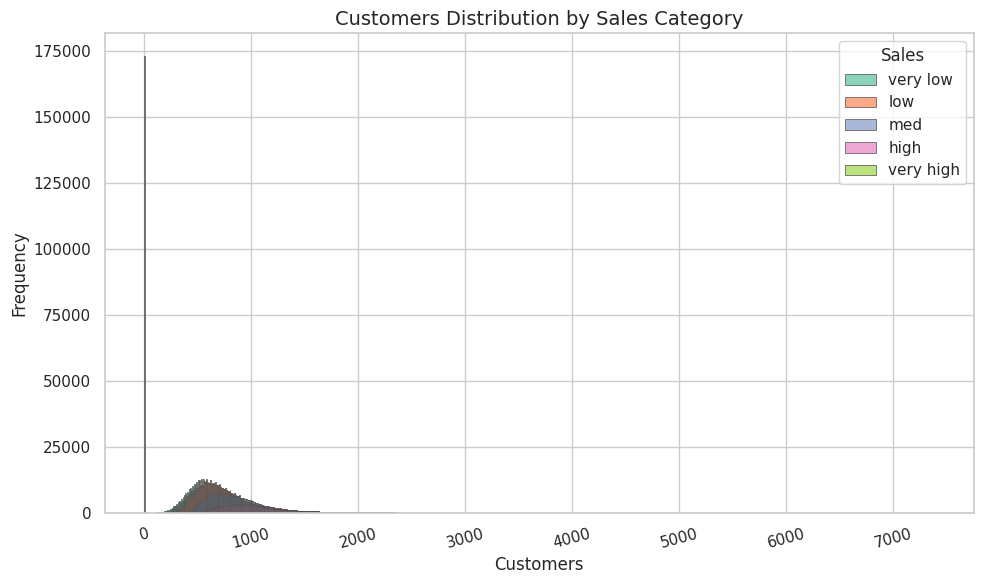

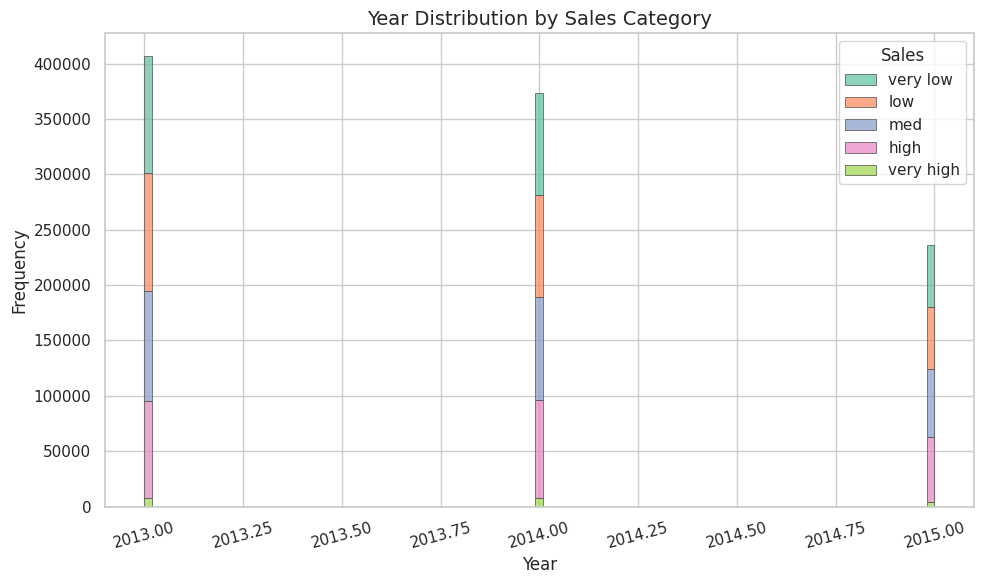

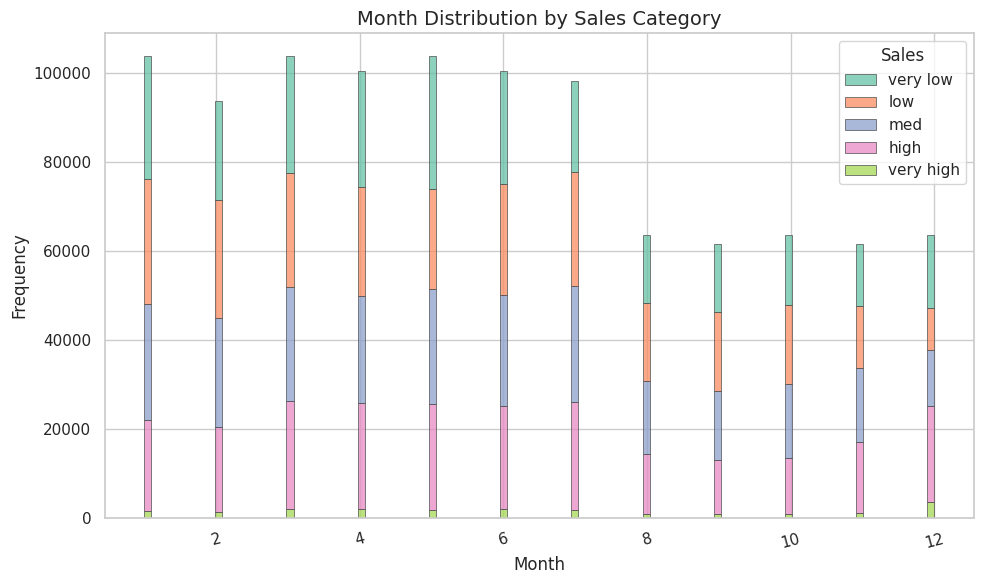

In [ ]:
# Set a clean, modern theme
sns.set(style="whitegrid")

# Loop through each column
for col in data.columns:
    plt.figure(figsize=(10, 6))  # Bigger figure for better readability

    # Plot with improved settings
    sns.histplot(data=data, x=col, hue=sales_category, multiple='stack', palette='Set2', edgecolor=".3", linewidth=0.5)

    # Add titles and labels
    plt.title(f"{col} Distribution by Sales Category", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    # plt.legend(title="Sales Category", fontsize=10, title_fontsize=11)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=15)

    # Show plot
    plt.tight_layout()
    plt.show()

### Boxplot

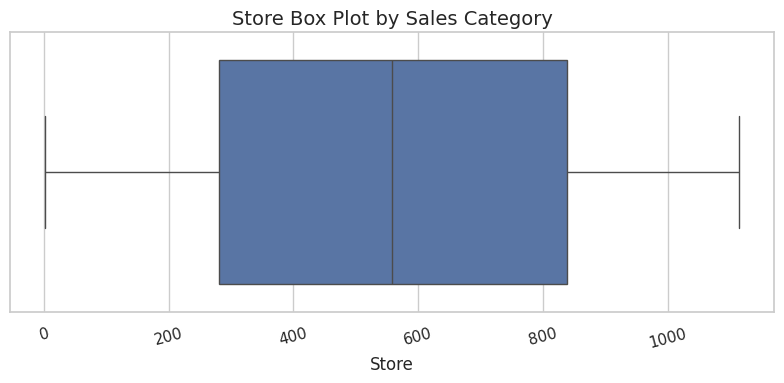

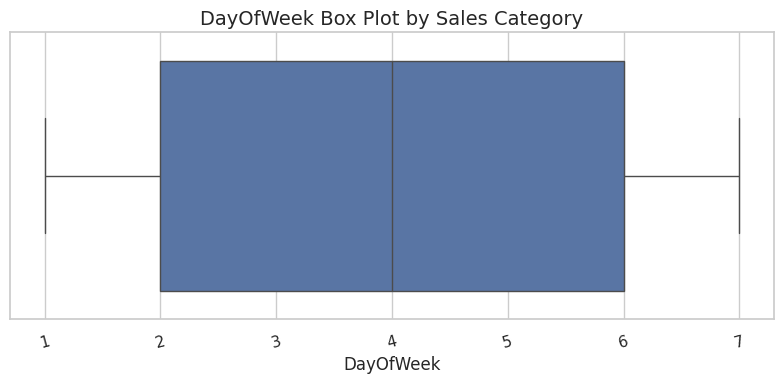

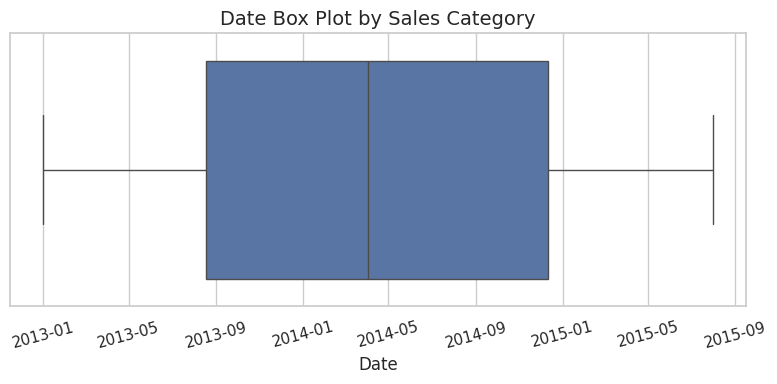

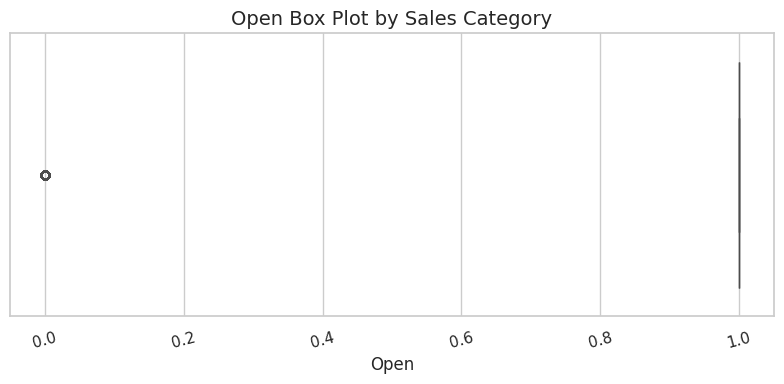

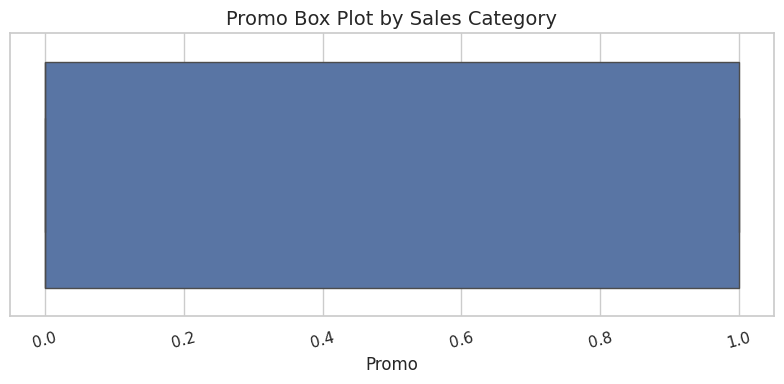

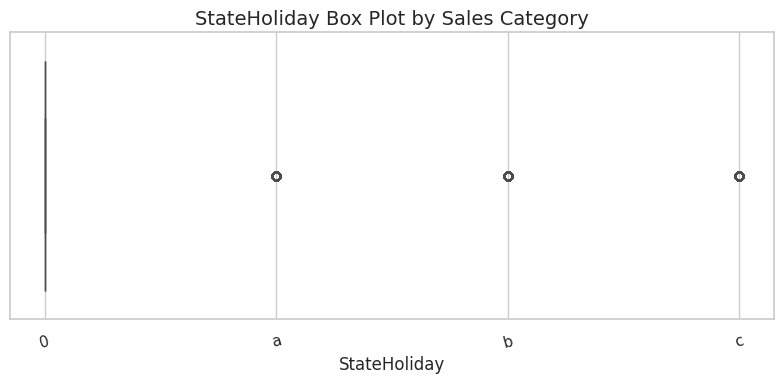

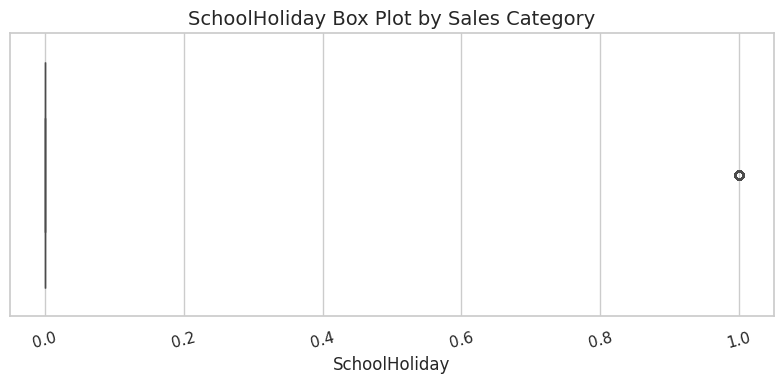

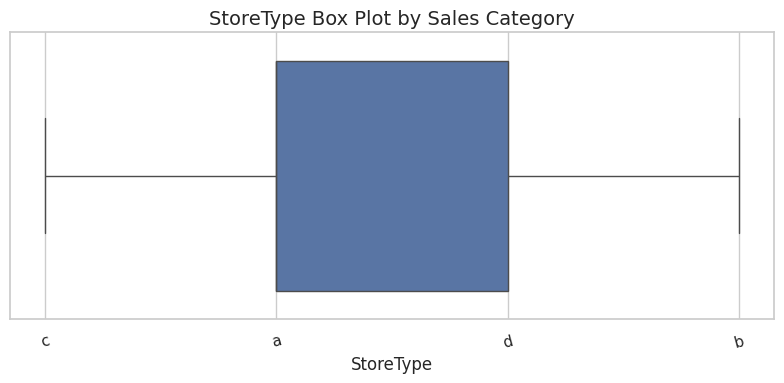

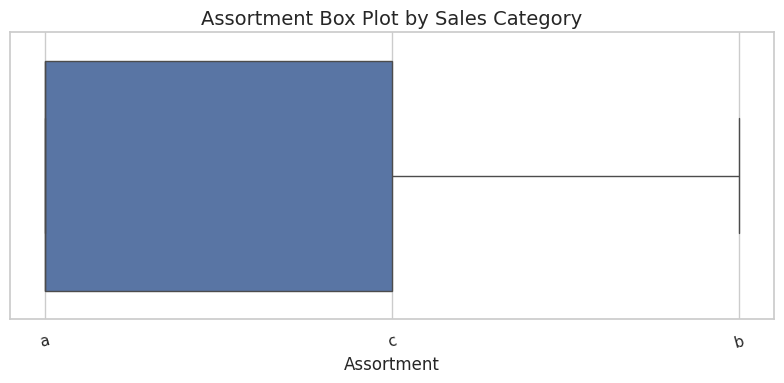

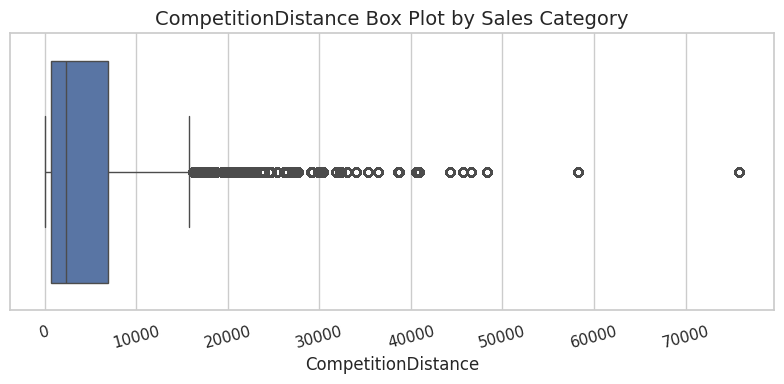

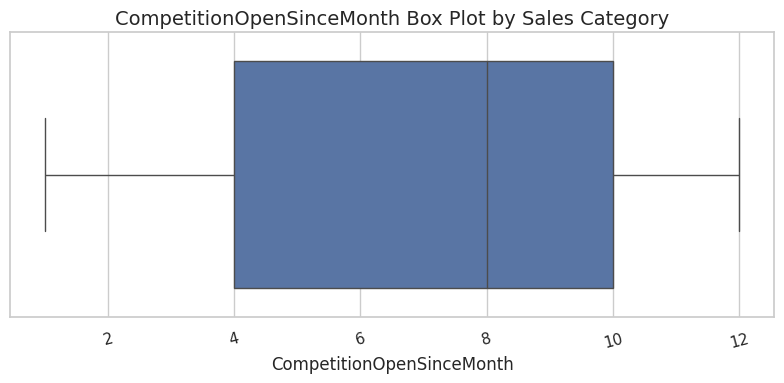

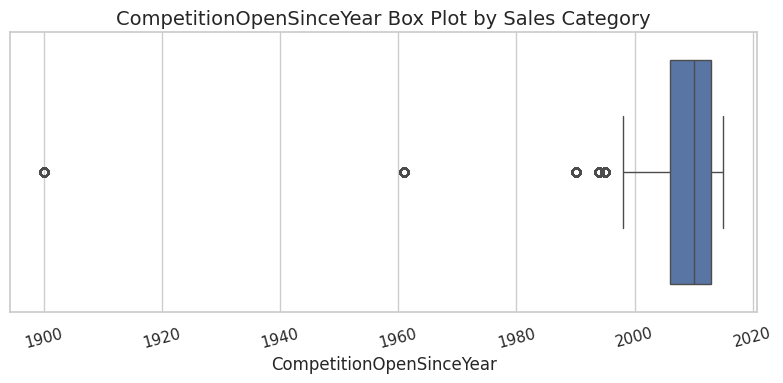

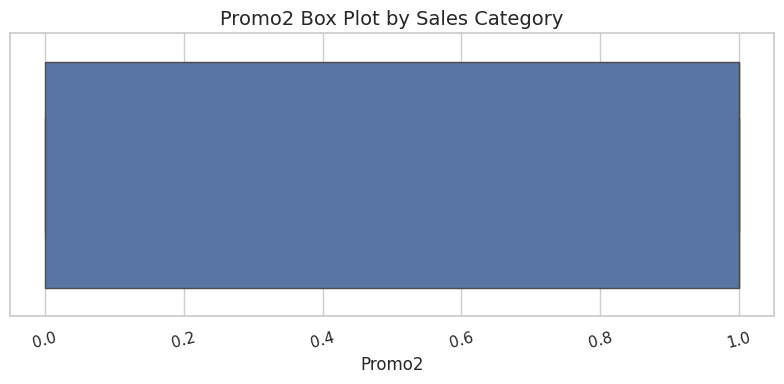

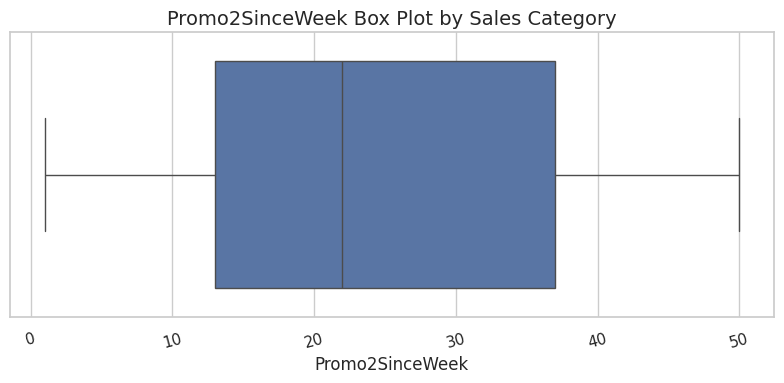

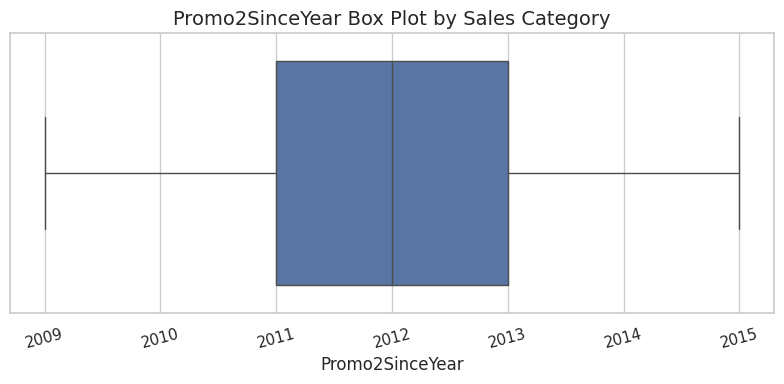

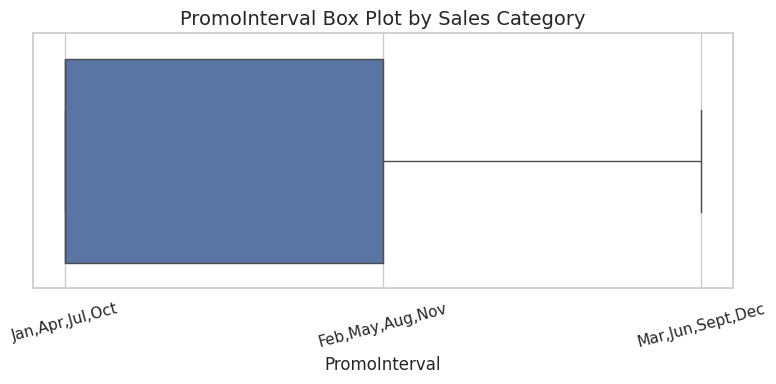

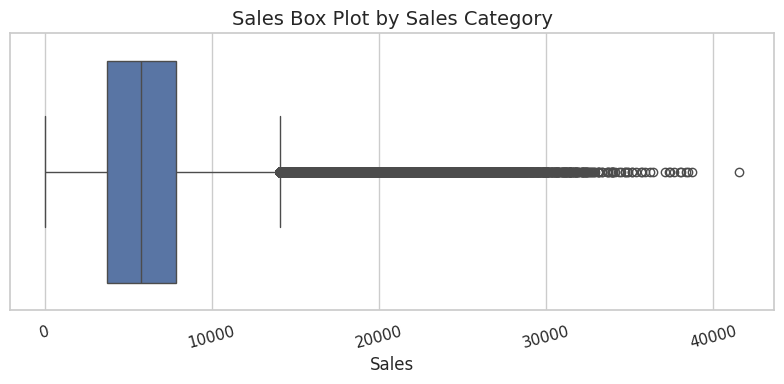

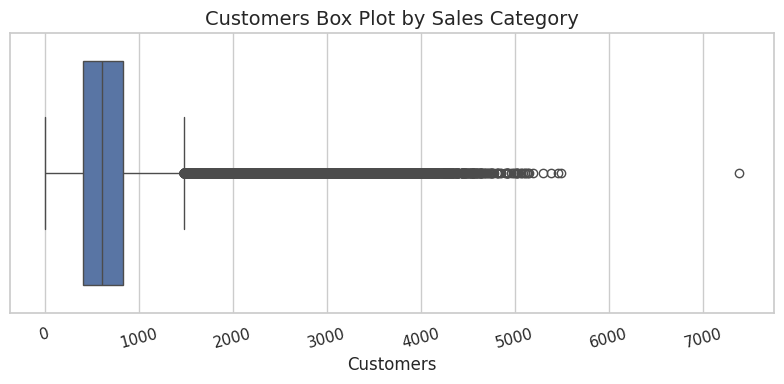

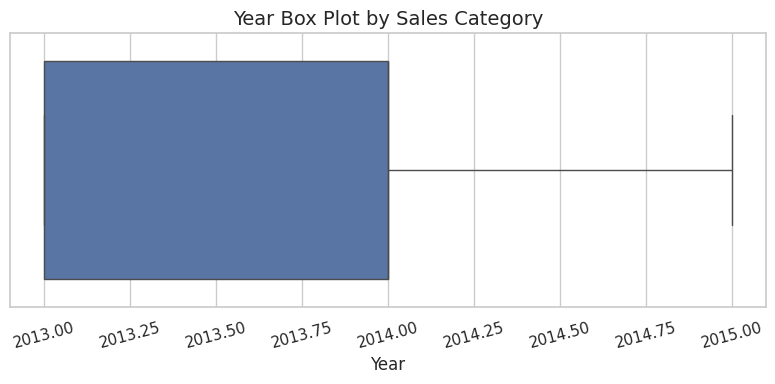

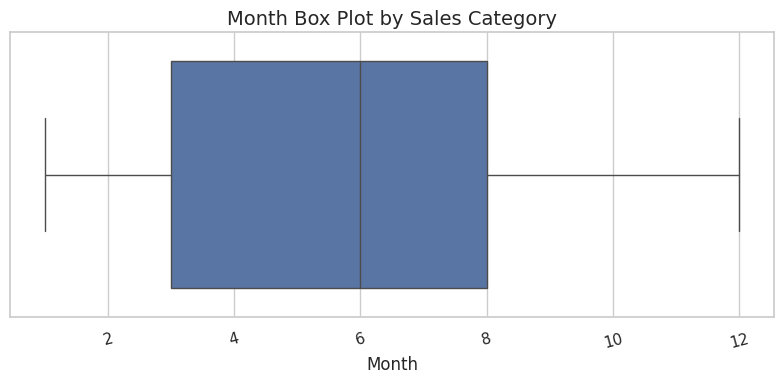

In [ ]:
# Set a clean, modern theme
sns.set(style="whitegrid")

# Loop through each column
for col in data.columns:
    plt.figure(figsize=(8, 4))  # Bigger figure for better readability

    # Plot with improved settings
    sns.boxplot(data=data, x=col)

    # Add titles and labels
    plt.title(f"{col} Box Plot by Sales Category", fontsize=14)
    plt.xlabel(col, fontsize=12)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=15)

    # Show plot
    plt.tight_layout()
    plt.show()

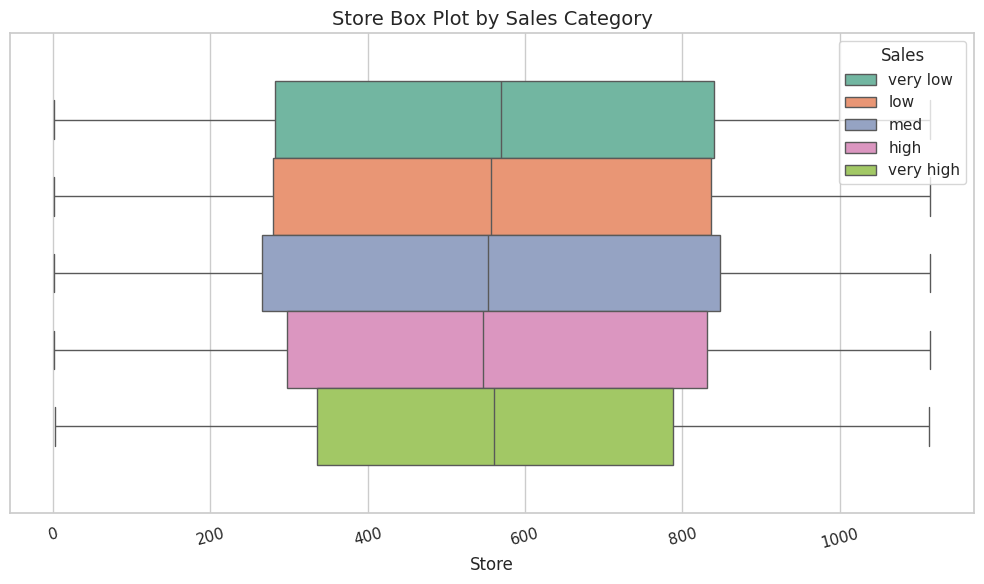

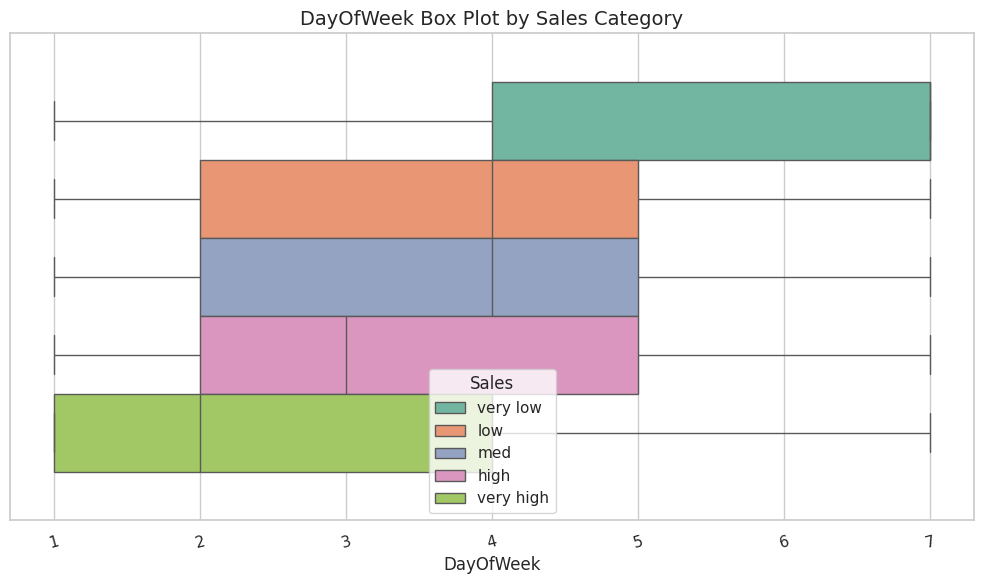

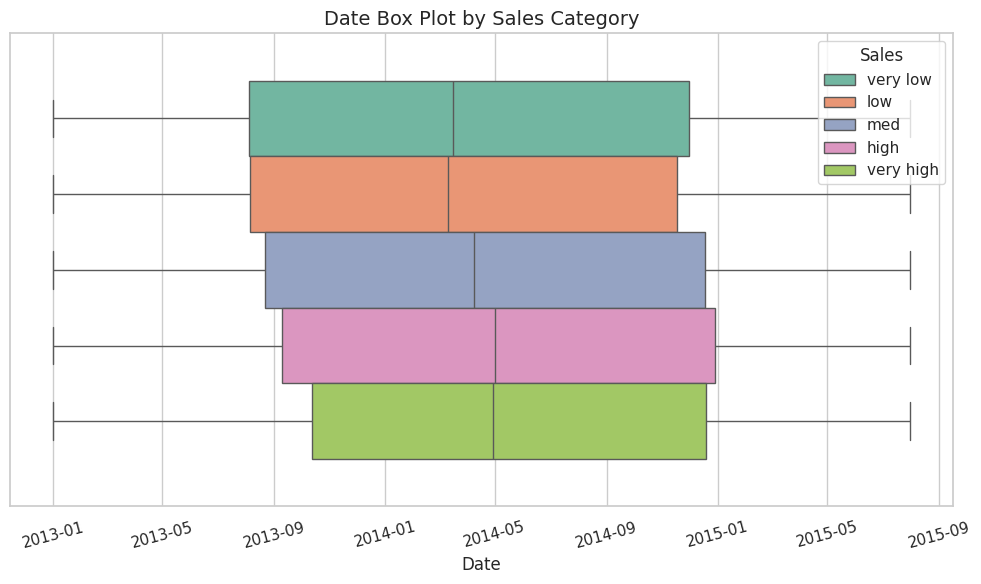

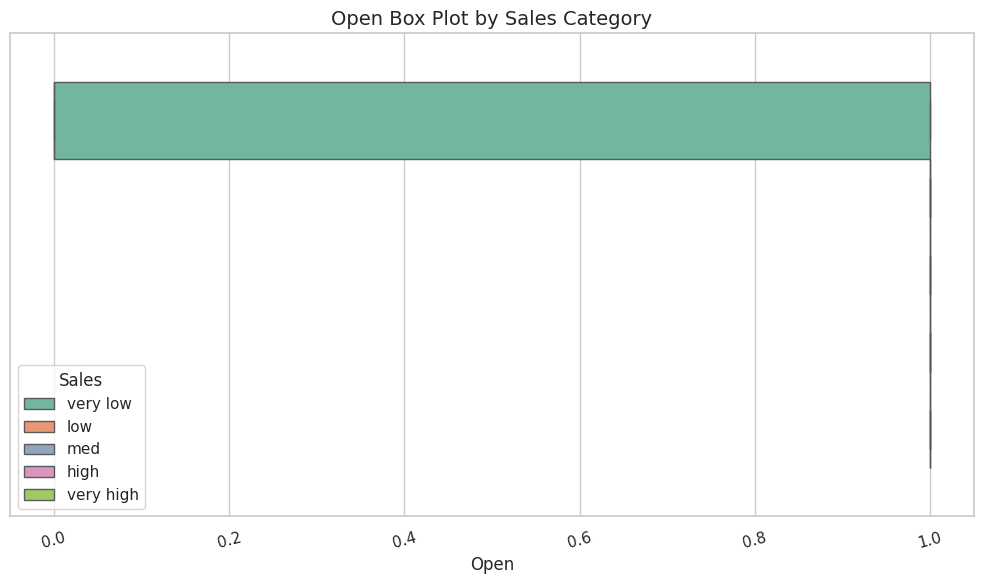

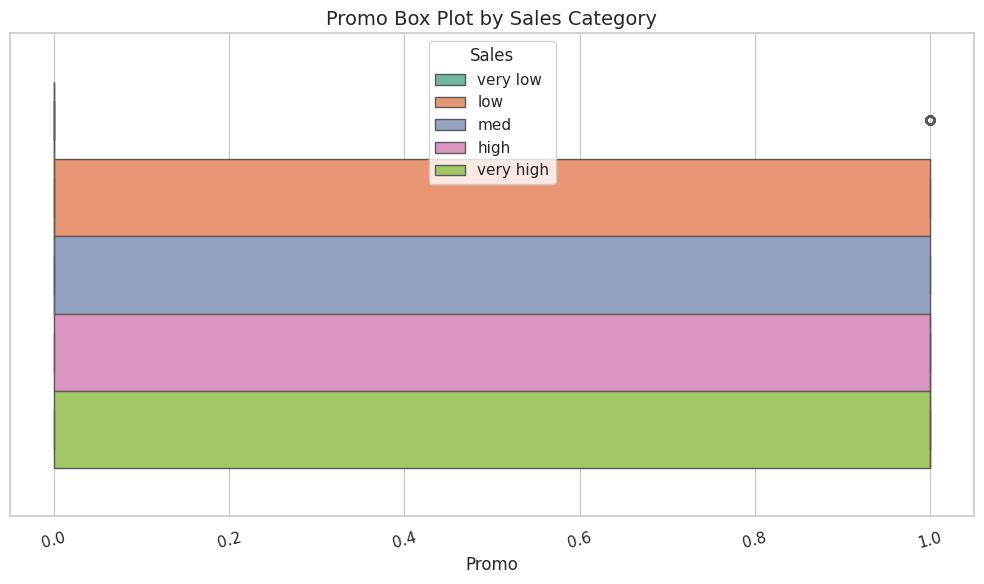

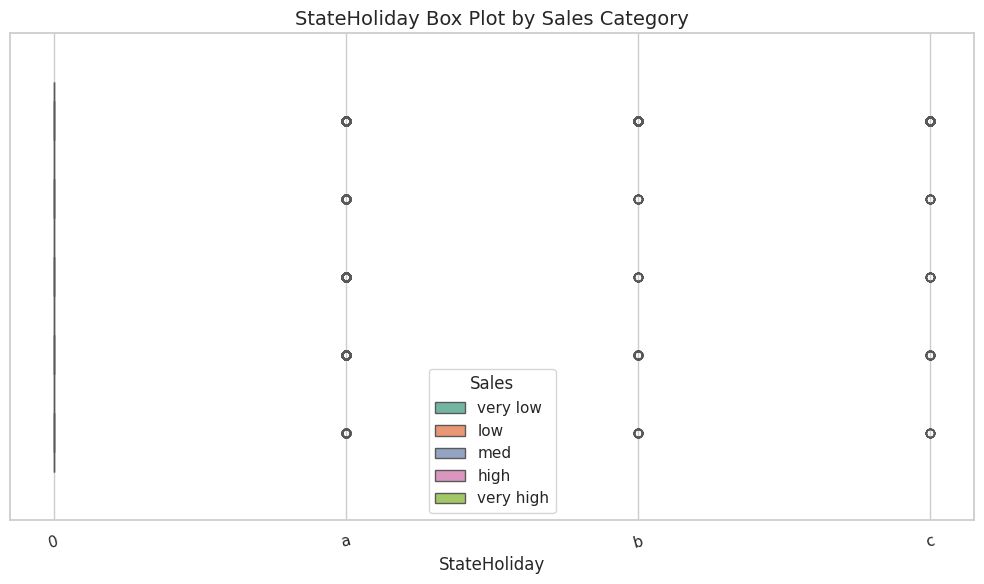

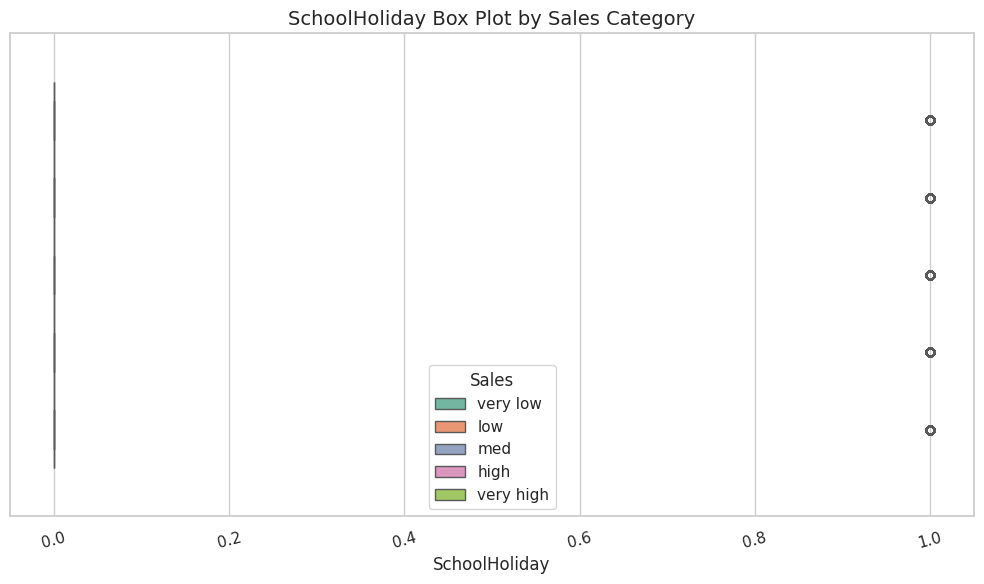

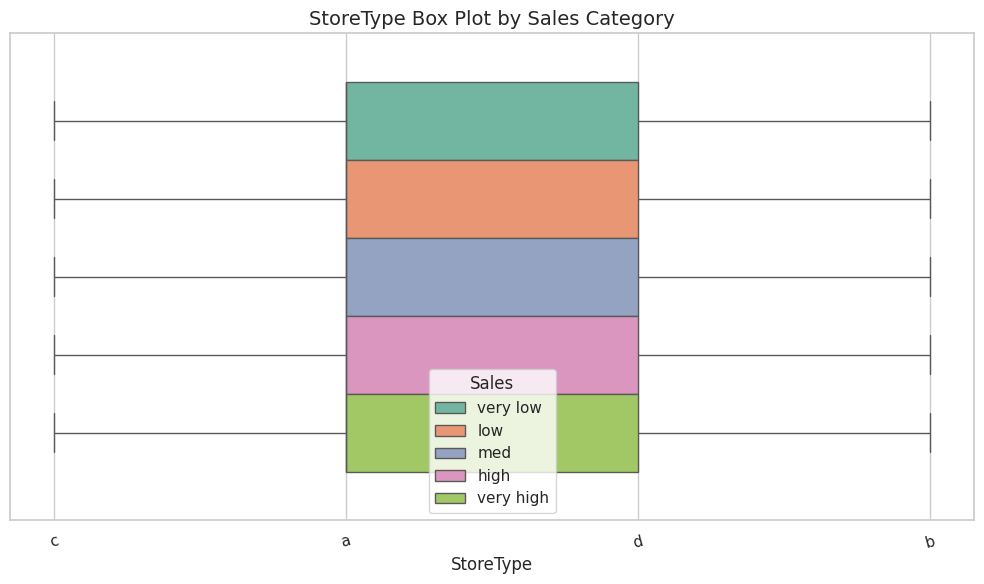

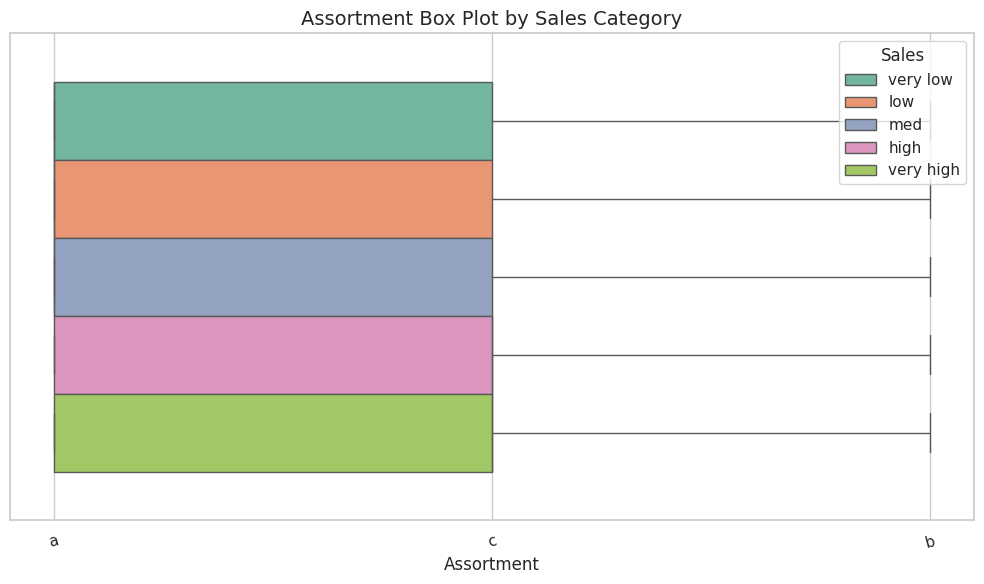

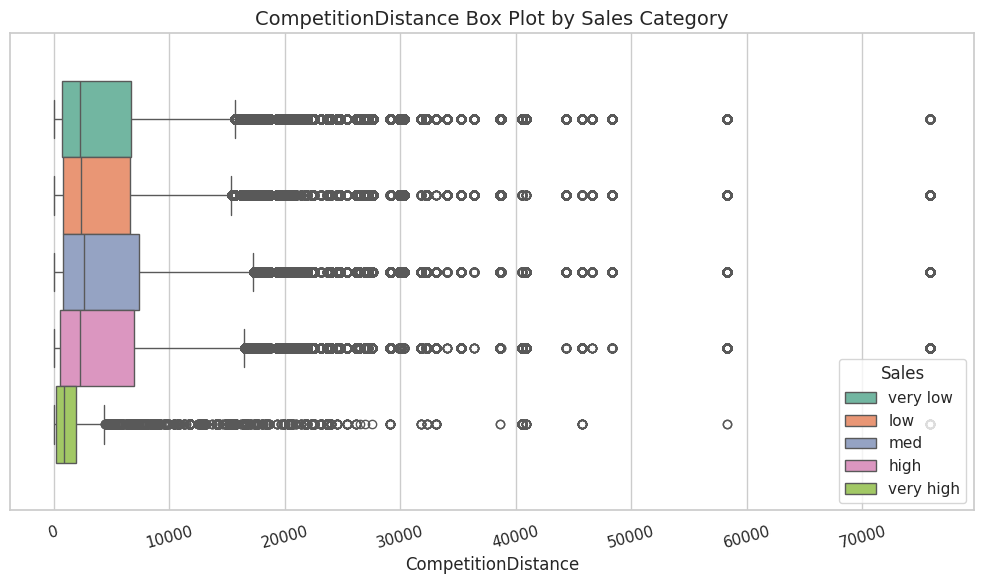

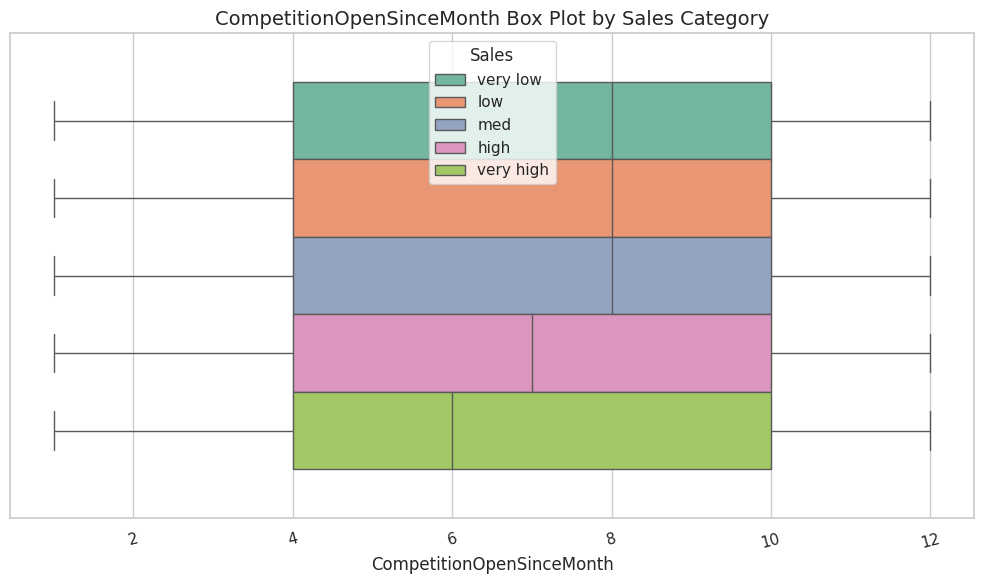

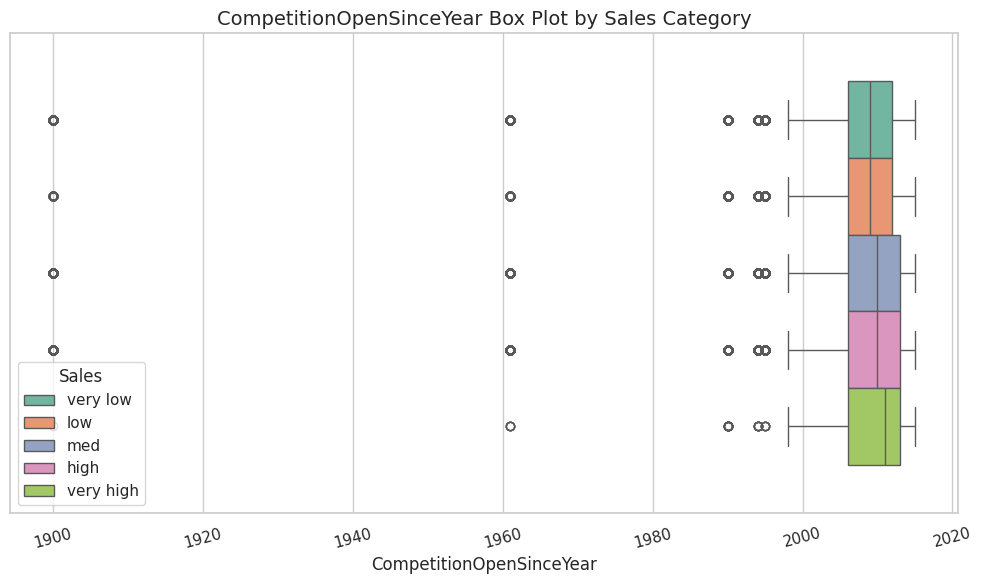

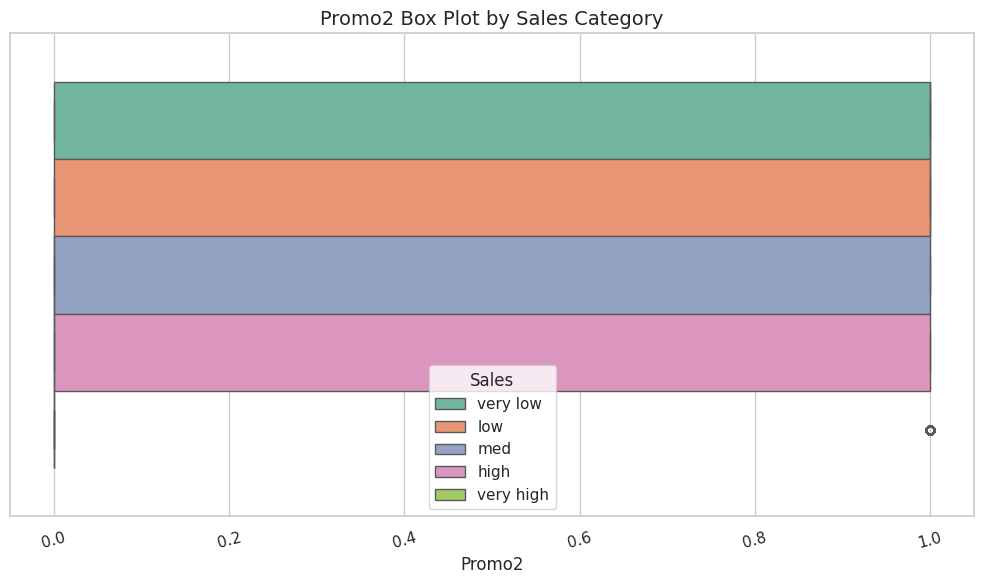

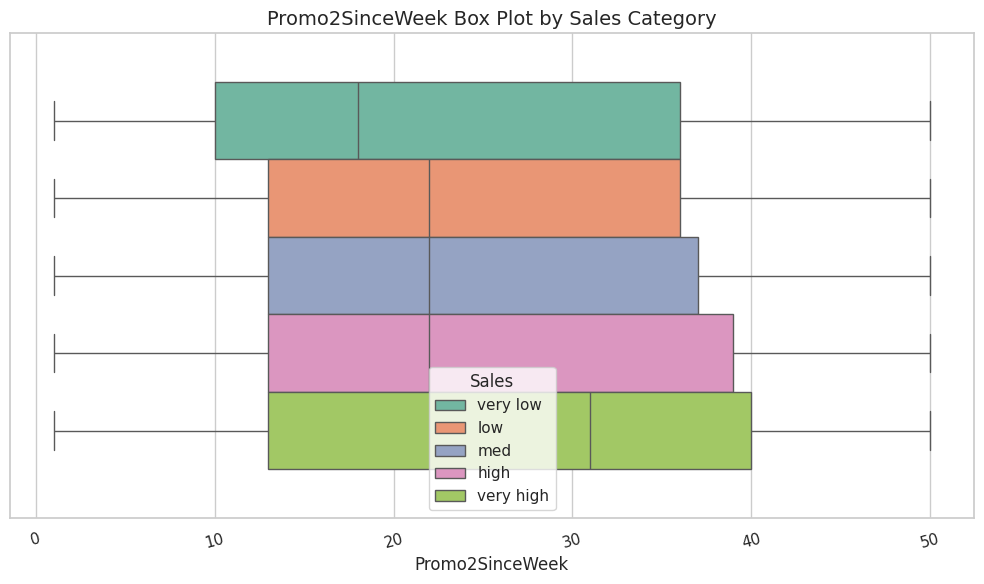

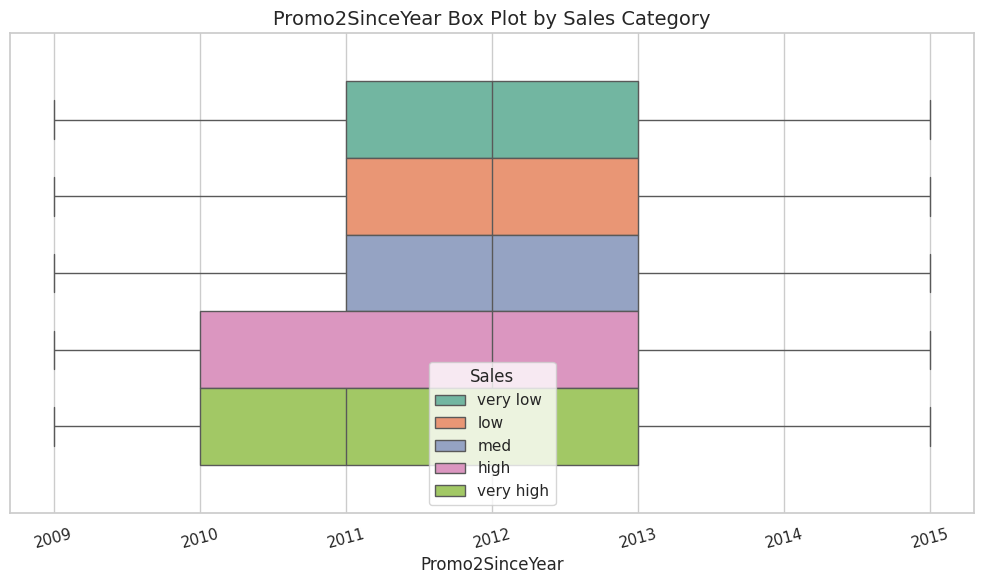

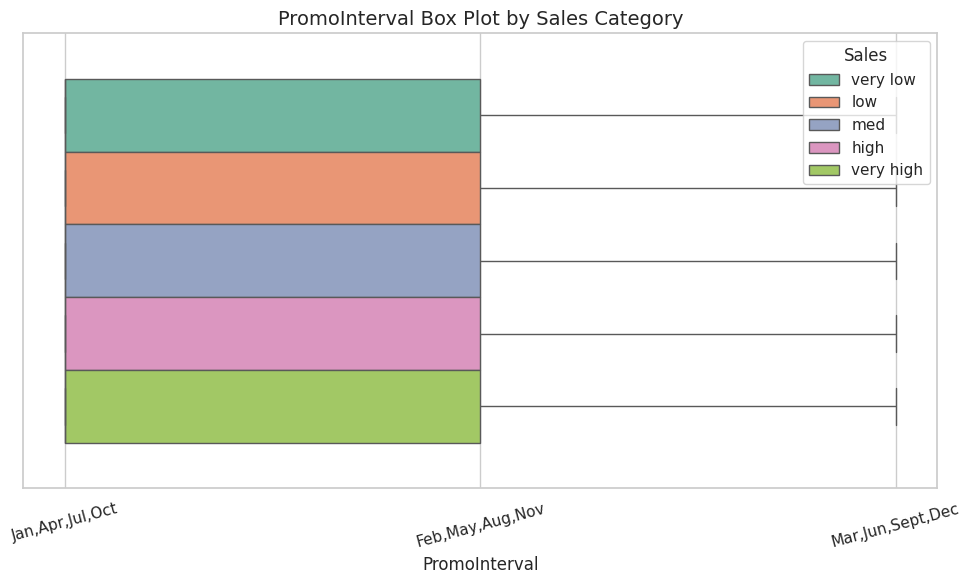

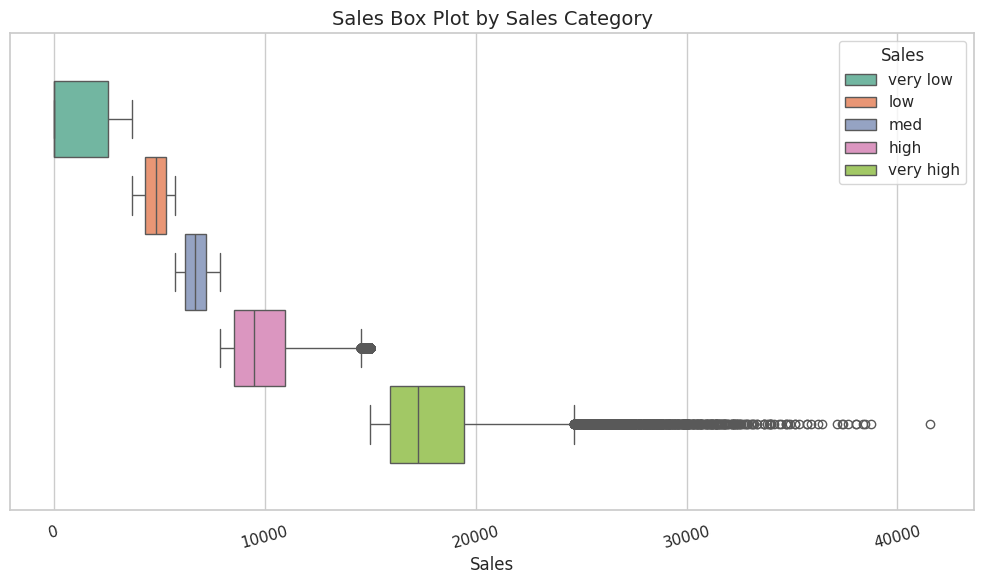

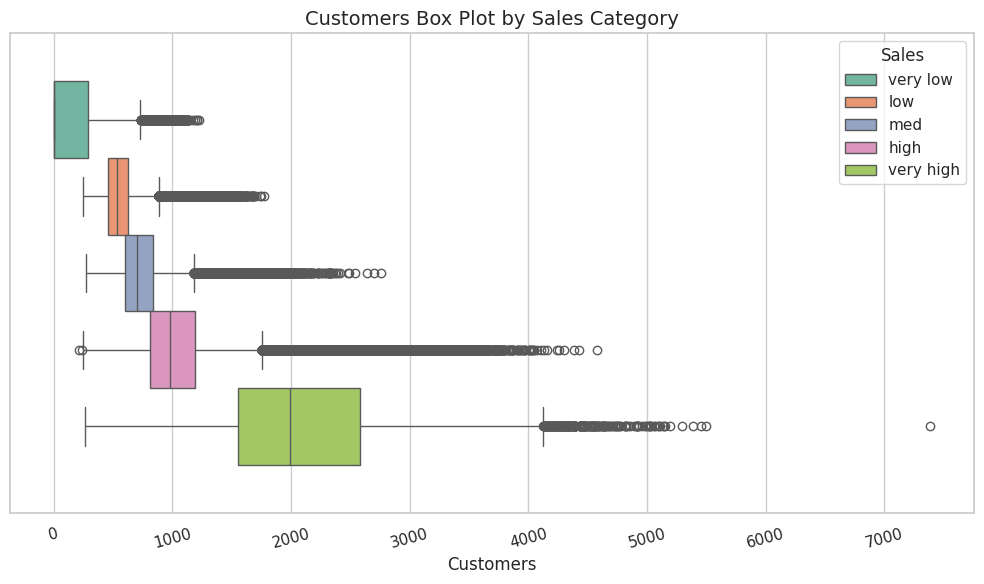

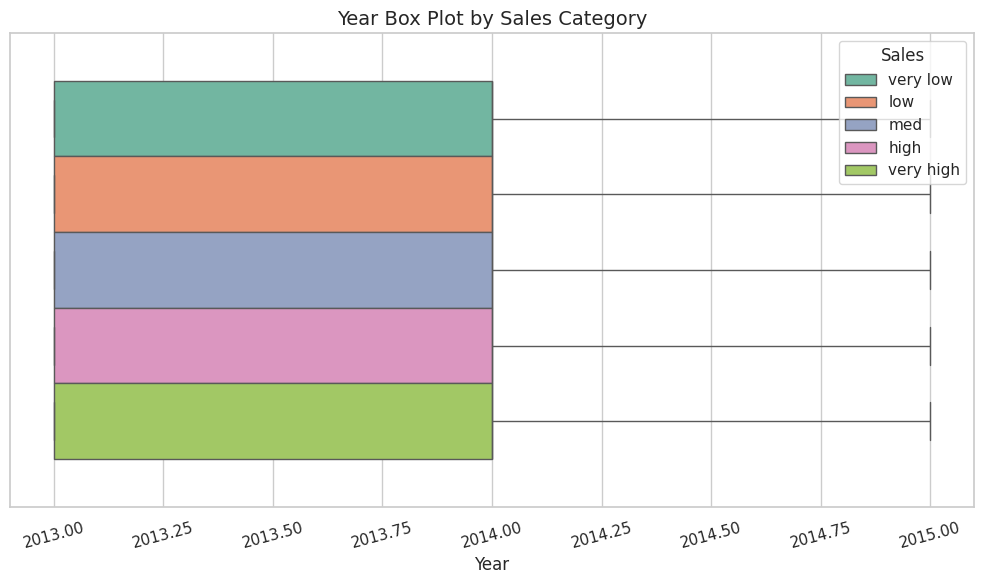

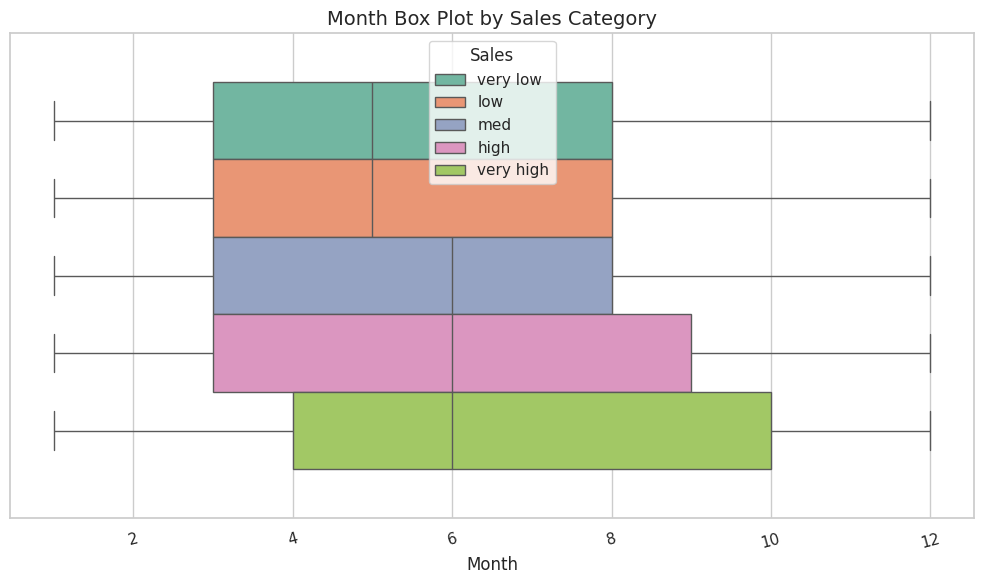

In [ ]:
# Set a clean, modern theme
sns.set(style="whitegrid")

# Loop through each column
for col in data.columns:
    plt.figure(figsize=(10, 6))  # Bigger figure for better readability

    # Plot with improved settings
    sns.boxplot(data=data, x=col, hue=sales_category, palette='Set2')

    # Add titles and labels
    plt.title(f"{col} Box Plot by Sales Category", fontsize=14)
    plt.xlabel(col, fontsize=12)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=15)

    # Show plot
    plt.tight_layout()
    plt.show()

### BarPlot

In [ ]:
data[(data["Open"] == 0) & (data["DayOfWeek"] == 7)]["Sales"].sum()

np.int64(0)

In [ ]:
data[(data["Open"] == 1) & (data["DayOfWeek"] == 7)]["Sales"].sum()

np.int64(29551433)

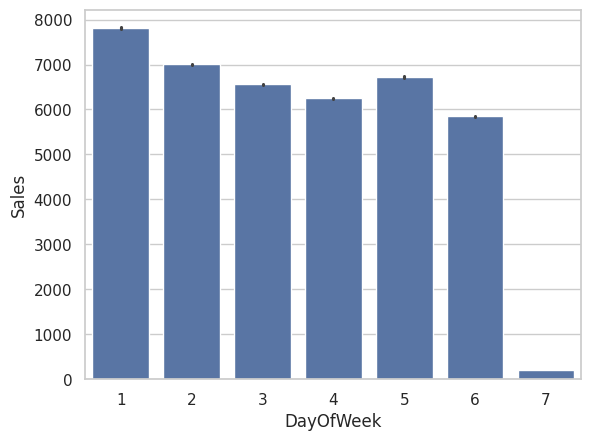

In [ ]:
sns.barplot(data, x="DayOfWeek", y="Sales")
plt.show()

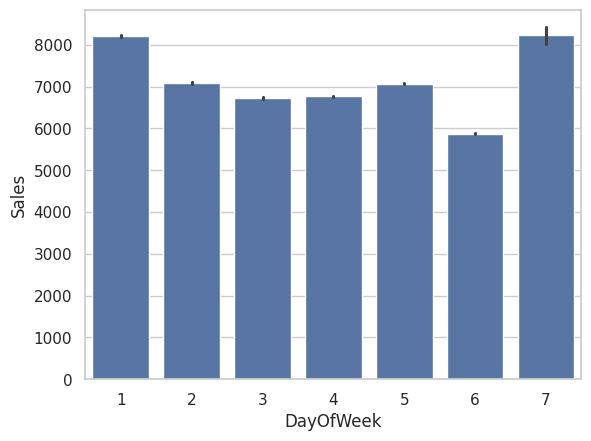

In [ ]:
sns.barplot(data=data[data["Open"] == 1], x="DayOfWeek", y="Sales")
plt.show()

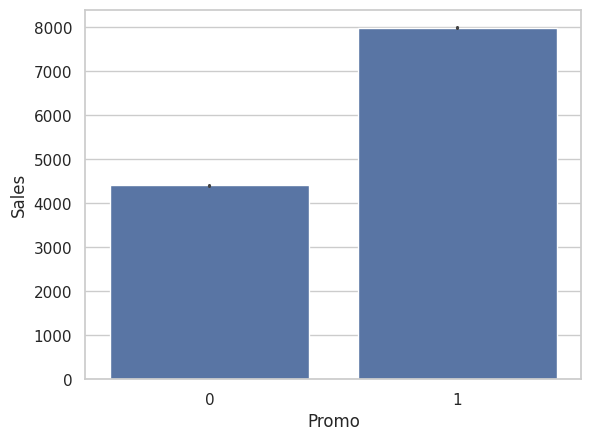

In [ ]:
sns.barplot(data=data, x='Promo', y='Sales')
plt.show()

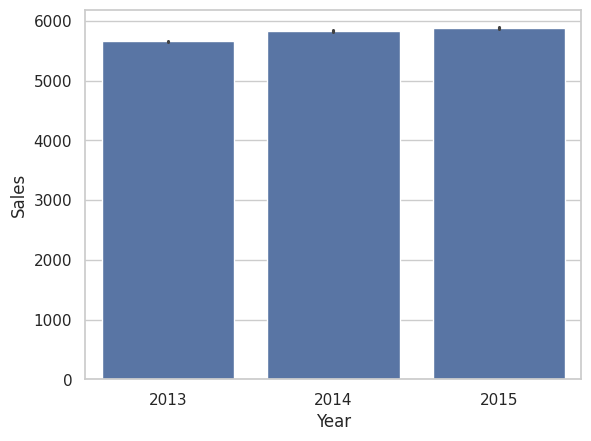

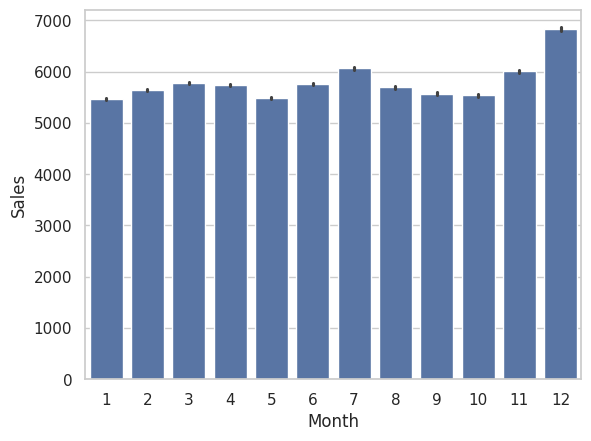

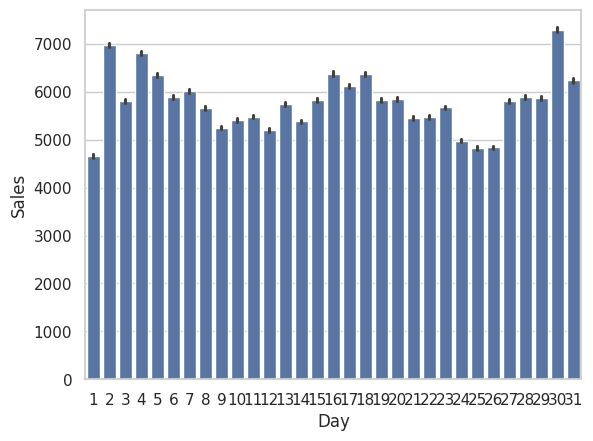

In [ ]:
for col in data_temp.columns[-3:]:
  sns.barplot(data=data_temp, x=col, y='Sales')
  plt.show()

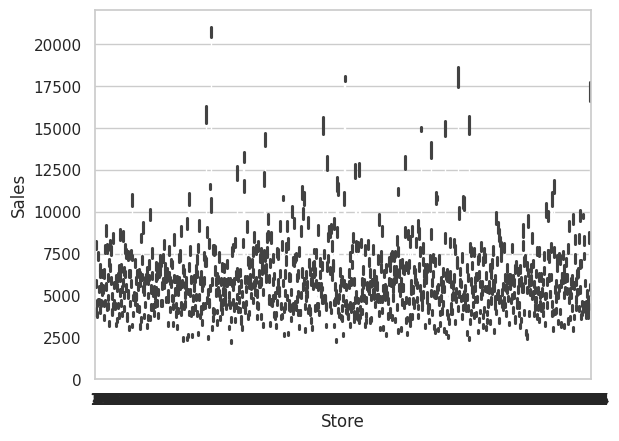

In [ ]:
sns.barplot(data, x="Store", y="Sales")
plt.show()

## **Target Variable Analysis**

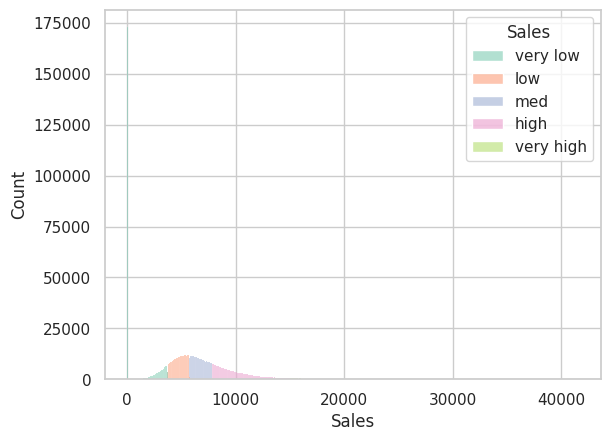

In [ ]:
sns.histplot(data=data, x=data["Sales"], hue=sales_category, palette="Set2")
plt.show()

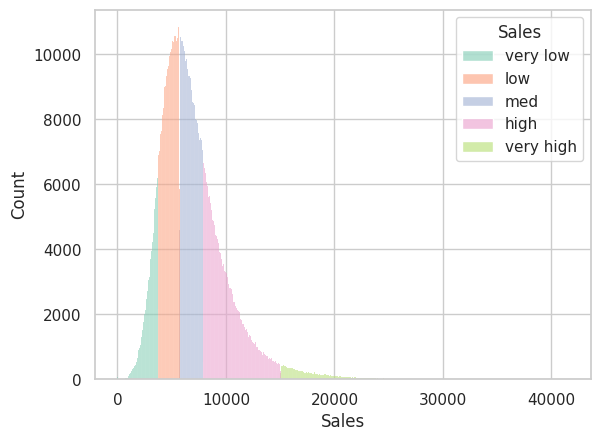

In [ ]:
sns.histplot(data=data[data["Open"] == 1], x="Sales", hue=sales_category, palette="Set2")
plt.show()

## **Plot Analyze Columns with NaNs**

In [ ]:
contain_nans_cols = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "CompetitionDistance"]

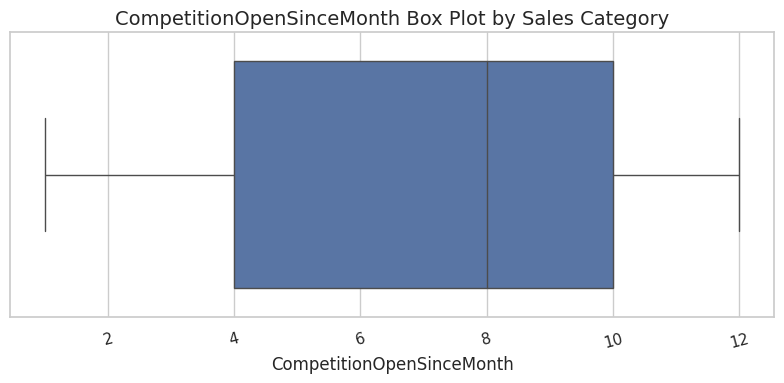

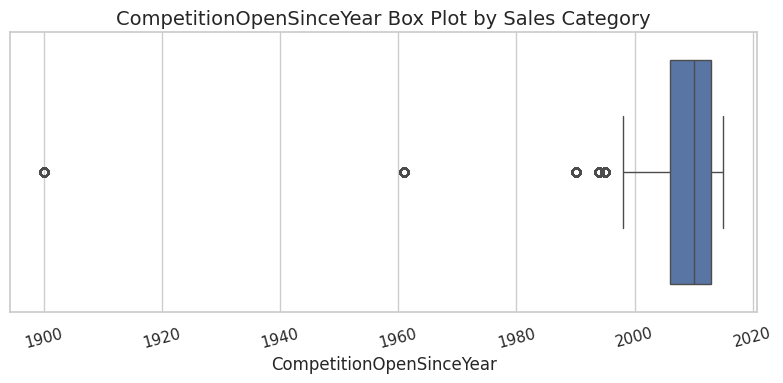

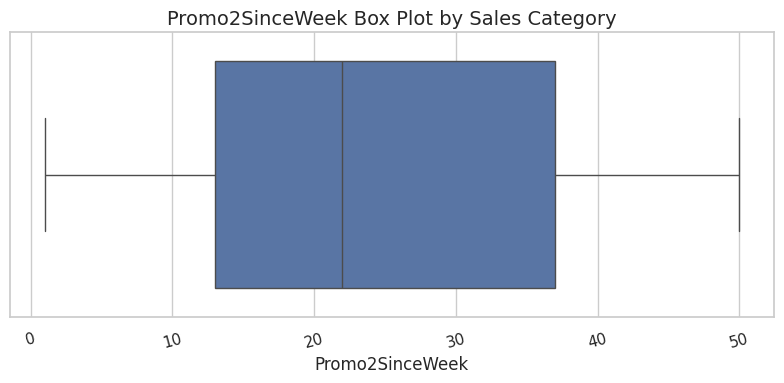

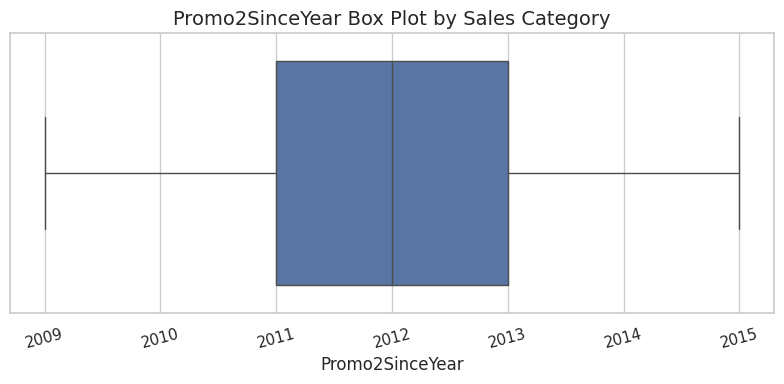

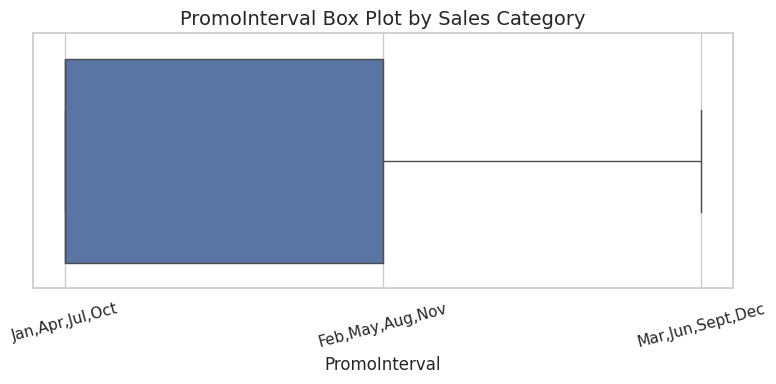

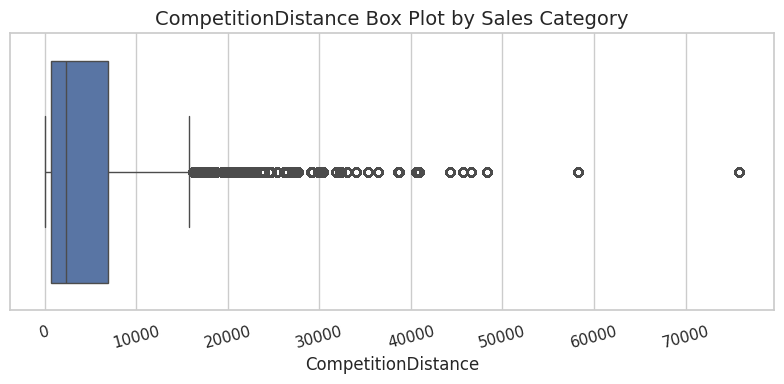

In [ ]:
# Loop through each column
for col in contain_nans_cols:
    plt.figure(figsize=(8, 4))  # Bigger figure for better readability

    # Plot with improved settings
    sns.boxplot(data=data, x=col)

    # Add titles and labels
    plt.title(f"{col} Box Plot by Sales Category", fontsize=14)
    plt.xlabel(col, fontsize=12)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=15)

    # Show plot
    plt.tight_layout()
    plt.show()

**Outliers**

CompetitionOpenSinceYear < 2000

CompetitionDistance > 16000

## **Analyze**
'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'

In [ ]:
categorical_cols_temp = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

### Barplot

In [ ]:
for col in categorical_cols_temp:
  sns.barplot(data, x=col, y="Sales")
  plt.show()

'Promo2SinceYear' as numerical

'PromoInterval' as categorical

# **Explore Columns With Nans**

In [ ]:
data[contain_nans_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 6 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   CompetitionOpenSinceMonth  693861 non-null   float64
 1   CompetitionOpenSinceYear   693861 non-null   float64
 2   Promo2SinceWeek            509178 non-null   float64
 3   Promo2SinceYear            509178 non-null   float64
 4   PromoInterval              509178 non-null   object 
 5   CompetitionDistance        1014567 non-null  float64
dtypes: float64(5), object(1)
memory usage: 46.6+ MB


In [ ]:
data[contain_nans_cols].nunique()

In [ ]:
data.nunique()

# ***Results***

**Tree-based models** (like Decision Trees, Random Forest, XGBoost), they are usually robust to outliers. You might keep them if they carry meaningful information.

**Outliers**

CompetitionOpenSinceYear < 2000

CompetitionDistance > 16000

Customers > 1500

SchoolHoliday == 1 Binary

StateHoliday exclude(0)

Open == 0 Binary

In [ ]:
drop_cols = ["Store", "Date"]
target_cols = ["Sales", "Customers"]
scalar_cols = ["CompetitionDistance"]
binary_cols = ["Open", "Promo", "SchoolHoliday", "Promo2"]
categorical_cols = [col for col in data.columns if col not in drop_cols + target_cols + scalar_cols + binary_cols]

In [ ]:
data[categorical_cols].nunique()

,0
DayOfWeek,7
StateHoliday,4
StoreType,4
Assortment,3
CompetitionOpenSinceMonth,12
CompetitionOpenSinceYear,23
Promo2SinceWeek,24
Promo2SinceYear,7
PromoInterval,3
Year,3
